# Capstone work: Aggregate dataframes from Craigslist and SF Crime: Rent Price estimator calculator based on reported crime rate. Areas with high crime rate generally have lower rent.

In [380]:
import pandas as pd
import numpy as np
import shapely

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [381]:
neighbors = pd.read_csv('./neighbors.csv')
del neighbors['Unnamed: 0']
neighbors.columns = ['polygon','neighborhoods']

neighbors.head()

,polygon,neighborhoods
0,MULTIPOLYGON (((-122.48408901116126 37.7879103...,Seacliff
1,MULTIPOLYGON (((-122.43596394723758 37.7690383...,Haight Ashbury
2,MULTIPOLYGON (((-122.45428355309251 37.7082221...,Outer Mission
3,MULTIPOLYGON (((-122.45143577030224 37.7587350...,Inner Sunset
4,MULTIPOLYGON (((-122.40891233260967 37.7901316...,Downtown/Civic Center


In [349]:
district_coordinates = pd.read_csv('./district_coordinates.csv')   # read in coordinates
del district_coordinates['Unnamed: 0']
district_coordinates = district_coordinates.dropna()

In [350]:
district_coordinates.head()  # 4 coordinate places is an accuracy of 11 meters

,district,lat,lon
0,bernal heights,37.7412,-122.4178
1,castro,37.7609,-122.4350
2,chinatown,37.7941,-122.4078
4,excelsior,37.7244,-122.4272
5,financial district,37.7946,-122.3999


In [351]:
#crime = pd.read_csv('./train.csv')    # read in crime
crime = pd.read_csv('./SFPD_Incidents_-_from_1_January_2003.csv')

In [352]:
crime_sub = crime.sample(100000)   #subset sample
crime_sub.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
509619,116158141,LARCENY/THEFT,PETTY THEFT AUTO STRIP,Saturday,12/10/2011,04:00,TARAVAL,NONE,500 Block of VICTORIA ST,-122.465305,37.720699,"(37.7206994601174, -122.465305223392)",11615814106233
76774,140211121,DRUG/NARCOTIC,POSSESSION OF COCAINE,Wednesday,03/12/2014,13:01,TENDERLOIN,"ARREST, BOOKED",200 Block of EDDY ST,-122.411800,37.784089,"(37.7840890366868, -122.411800134753)",14021112116620
1462412,116093600,LARCENY/THEFT,GRAND THEFT AUTO STRIP,Wednesday,07/20/2011,19:00,RICHMOND,NONE,20TH AV / ANZA ST,-122.479239,37.778407,"(37.778406768752, -122.479239266729)",11609360006234
1164944,90316544,ASSAULT,THREATS AGAINST LIFE,Thursday,03/26/2009,07:30,NORTHERN,NONE,800 Block of ELLIS ST,-122.420191,37.783870,"(37.7838703920898, -122.42019129512)",9031654419057
892592,40131314,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Monday,02/02/2004,01:15,MISSION,NONE,3400 Block of 19TH ST,-122.421048,37.760179,"(37.7601791935819, -122.421047623733)",4013131406373


## Get polygons into a dictionary file

In [353]:
## POLYGONS

import json

with open('./neighbourhoods.geojson') as f:
    data = json.load(f)
#print data
geom_polys = {}
for feature,neighborhood in zip(data['features'],neighbors.neighborhoods):
    geom = feature['geometry']['coordinates'][0][0]
    print neighborhood
    geom_polys[neighborhood] = [geom]
    
#geom_polys.pop('area')

Seacliff
Haight Ashbury
Outer Mission
Inner Sunset
Downtown/Civic Center
Diamond Heights
Lakeshore
Russian Hill
Noe Valley
Treasure Island/YBI
Outer Richmond
Crocker Amazon
Excelsior
Parkside
Financial District
Ocean View
Mission
West of Twin Peaks
Inner Richmond
Marina
Bayview
Visitacion Valley
Pacific Heights
Presidio Heights
South of Market
Glen Park
Potrero Hill
Castro/Upper Market
Twin Peaks
Bernal Heights
Presidio
Nob Hill
Chinatown
North Beach
Outer Sunset
Western Addition
Golden Gate Park


In [354]:
geom_polys = pd.DataFrame(geom_polys).T
geom_polys.head()

,0
Bayview,"[[-122.388108, 37.747803], [-122.3881, 37.7477..."
Bernal Heights,"[[-122.428255, 37.731785], [-122.428147, 37.73..."
Castro/Upper Market,"[[-122.446438, 37.761036], [-122.446408, 37.76..."
Chinatown,"[[-122.447983, 37.806972], [-122.447876, 37.80..."
Crocker Amazon,"[[-122.42085, 37.708335], [-122.423878, 37.708..."


In [355]:
district_coordinates.head() # messed up iwth lat lon

,district,lat,lon
0,bernal heights,37.7412,-122.4178
1,castro,37.7609,-122.4350
2,chinatown,37.7941,-122.4078
4,excelsior,37.7244,-122.4272
5,financial district,37.7946,-122.3999


In [356]:
crime_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 509619 to 263198
Data columns (total 13 columns):
IncidntNum    100000 non-null int64
Category      100000 non-null object
Descript      100000 non-null object
DayOfWeek     100000 non-null object
Date          100000 non-null object
Time          100000 non-null object
PdDistrict    100000 non-null object
Resolution    100000 non-null object
Address       100000 non-null object
X             100000 non-null float64
Y             100000 non-null float64
Location      100000 non-null object
PdId          100000 non-null int64
dtypes: float64(2), int64(2), object(9)
memory usage: 10.7+ MB


## check distance of matched district using scraped google coordinates from district_coordinates dataframe

# Function to map crime location coordinates to districts

In [357]:
# get decimals as a feature X1 X2 from the location coordinates
from decimal import Decimal
def replace_lon(location):
    
    lon = str(location).replace('(','').replace(')','').split(',')
    lon = np.float64(lon[1])
    return lon
    
def replace_lat(location):
    lat = str(location).replace('(','').replace(')','').split(',')
    lat = np.float64(lat[0])
    return lat
    
crime_sub['X1'] = crime_sub.apply(lambda row: replace_lon(row['Location']),axis = 1)
crime_sub['Y1'] = crime_sub.apply(lambda row: replace_lat(row['Location']),axis = 1)

In [358]:
# haversine distances to check which crime occured in what district
%timeit
from haversine import haversine
def check_distance(location):
    #print location
    haversine_list = []
    for d,lat,lon in zip(district_coordinates.district,district_coordinates.lat, district_coordinates.lon):

        haversine_list.append((haversine(location, (lon,lat)),d))
    
    match = sorted(haversine_list)[0][1]
    return match
    
crime_sub['match_district'] = crime_sub.apply(lambda row: check_distance((row['X1'],row['Y1'])), axis = 1 )

In [359]:
crime_sub.head(2)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,X1,Y1,match_district
509619,116158141,LARCENY/THEFT,PETTY THEFT AUTO STRIP,Saturday,12/10/2011,04:00,TARAVAL,NONE,500 Block of VICTORIA ST,-122.465305,37.720699,"(37.7206994601174, -122.465305223392)",11615814106233,-122.465305,37.720699,oceanview
76774,140211121,DRUG/NARCOTIC,POSSESSION OF COCAINE,Wednesday,03/12/2014,13:01,TENDERLOIN,"ARREST, BOOKED",200 Block of EDDY ST,-122.411800,37.784089,"(37.7840890366868, -122.411800134753)",14021112116620,-122.411800,37.784089,tenderloin


## Create crime categories for classification of crime types for EDA

In [360]:
# create crime Categories
crime_sub.Category.value_counts()

theft = ['LARCENY/THEFT','VEHICLE THEFT','BURGLARY','ROBBERY','STOLEN PROPERTY','RECOVERED VEHICLE']
drunk = ['DRUG/NARCOTIC','DRUNKENNESS','LIQOUR LAWS','DRIVING UNDER THE INFLUENCE','LIQUOR LAWS']
organized = ['BRIBERY','EXTORTION','PROSTITUTION']
violent = ['ASSAULT','SEX OFFENSES, FORCIBLE','KIDNAPPING']
narcotic = ['DRUG/NARCOTIC']
city = ['VANDALISM','LOITERING']

In [361]:
crime_sub['is_theft'] = crime_sub.Category.apply(lambda x: 1 if x in theft else 0)
crime_sub['is_drunk'] = crime_sub.Category.apply(lambda x: 1 if x in drunk else 0)
crime_sub['is_organized'] = crime_sub.Category.apply(lambda x: 1 if x in organized else 0)
crime_sub['is_violent'] = crime_sub.Category.apply(lambda x: 1 if x in violent else 0)
crime_sub['is_narcotic'] = crime_sub.Category.apply(lambda x: 1 if x in narcotic else 0)
crime_sub['is_city'] = crime_sub.Category.apply(lambda x: 1 if x in city else 0)

In [362]:
crime_sub.head(2)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,...,PdId,X1,Y1,match_district,is_theft,is_drunk,is_organized,is_violent,is_narcotic,is_city
509619,116158141,LARCENY/THEFT,PETTY THEFT AUTO STRIP,Saturday,12/10/2011,04:00,TARAVAL,NONE,500 Block of VICTORIA ST,-122.465305,...,11615814106233,-122.465305,37.720699,oceanview,1,0,0,0,0,0
76774,140211121,DRUG/NARCOTIC,POSSESSION OF COCAINE,Wednesday,03/12/2014,13:01,TENDERLOIN,"ARREST, BOOKED",200 Block of EDDY ST,-122.411800,...,14021112116620,-122.411800,37.784089,tenderloin,0,1,0,0,1,0


# kiefers function

%time
from scipy.spatial import distance
import matplotlib.path as mplPath
from haversine import haversine

class PolyPaths():
    
    def __init__(self, geom_polys, centroid_lats, centroid_lons):   
        self.polys = {k:mplPath.Path(v[0][0]) for k,v in geom_polys.items()} #iterate through key value pairs of geoms
        self.lats = centroid_lats     # centroids
        self.lons = centroid_lons
        
    def districts_with_point(self, location):
        return [k for k,v in self.polys.items() if v.contains_point(location)]    # if it contains point return district
    
    def closest_district(self, location, districts):
        distances = [(haversine(location, (self.lats[d], self.lons[d])), d) for d in districts] 
        print distances
        return sorted(distances)[0]   #closest district function
    
    def find_district_match(self, location):
        district_options = self.districts_with_point(location)
        if len(district_options) == 0:
            return 'unknown'
        elif len(district_options) == 1:   
            return district_options[0]
        else:
            return self.closest_district(location, district_options)

        
poly_parser = PolyPaths(geom_polys, centroid_lat, centroid_lon)

crime_sub['matched_district'] = crime_sub.apply(lambda row: poly_parser.find_district_match((row['X1'],row['Y1'])),axis = 1)

## Convert indexes and dates to datetime

In [363]:
from datetime import datetime as dt
print crime_sub.index.dtype
crime_sub['Date'] = pd.to_datetime(crime_sub['Date'])
crime_sub.set_index('Date',inplace= True)
print crime_sub.index.dtype

int64
datetime64[ns]


In [364]:
crime_sub.index

DatetimeIndex(['2011-12-10', '2014-03-12', '2011-07-20', '2009-03-26',
               '2004-02-02', '2014-03-17', '2007-10-09', '2011-12-19',
               '2015-03-02', '2011-06-07',
               ...
               '2004-04-06', '2005-07-27', '2003-01-22', '2010-02-07',
               '2006-12-17', '2010-05-28', '2011-08-17', '2015-02-06',
               '2004-01-15', '2010-04-28'],
              dtype='datetime64[ns]', name=u'Date', length=100000, freq=None)

In [615]:
# create a year function, 2016 is not completely represented
crime_sub['year'] = crime_sub.index.map(lambda val: val.year)
crime_sub.head(1)
crime_sub = crime_sub[crime_sub['year'] < 2016]

In [616]:
crime_sub.year.value_counts()

2015    8255
2013    8036
2014    7938
2004    7795
2003    7724
2012    7417
2005    7373
2009    7311
2008    7301
2006    7132
2007    7058
2010    6970
2011    6940
Name: year, dtype: int64

# posts clean up

In [707]:
posts = pd.read_csv('./craigslist_posts.csv')
posts.head()
posts = posts[posts.bed < 6]

# *EDA*

In [617]:
crime_sub.Resolution.value_counts()[0:5]

NONE                 59136
ARREST, BOOKED       22782
ARREST, CITED         8072
LOCATED               1799
PSYCHOPATHIC CASE     1449
Name: Resolution, dtype: int64

In [618]:
crime_eda = crime_sub[['Category','Resolution','match_district','is_theft','is_organized','is_violent','is_narcotic','is_city','year']]
crime_eda.head()

,Category,Resolution,match_district,is_theft,is_organized,is_violent,is_narcotic,is_city,year
Date,,,,,,,,,
2011-12-10,LARCENY/THEFT,NONE,oceanview,1,0,0,0,0,2011
2014-03-12,DRUG/NARCOTIC,"ARREST, BOOKED",tenderloin,0,0,0,1,0,2014
2011-07-20,LARCENY/THEFT,NONE,golden gate park,1,0,0,0,0,2011
2009-03-26,ASSAULT,NONE,tenderloin,0,0,1,0,0,2009
2004-02-02,LARCENY/THEFT,NONE,mission district,1,0,0,0,0,2004


In [944]:
crime_eda.groupby('year').sum().head()

,is_theft,is_organized,is_violent,is_narcotic,is_city
year,,,,,
2003,2666,96,754,534,312
2004,2798,89,712,535,347
2005,2797,71,631,441,376
2006,2447,76,659,461,396
2007,2207,118,717,542,376


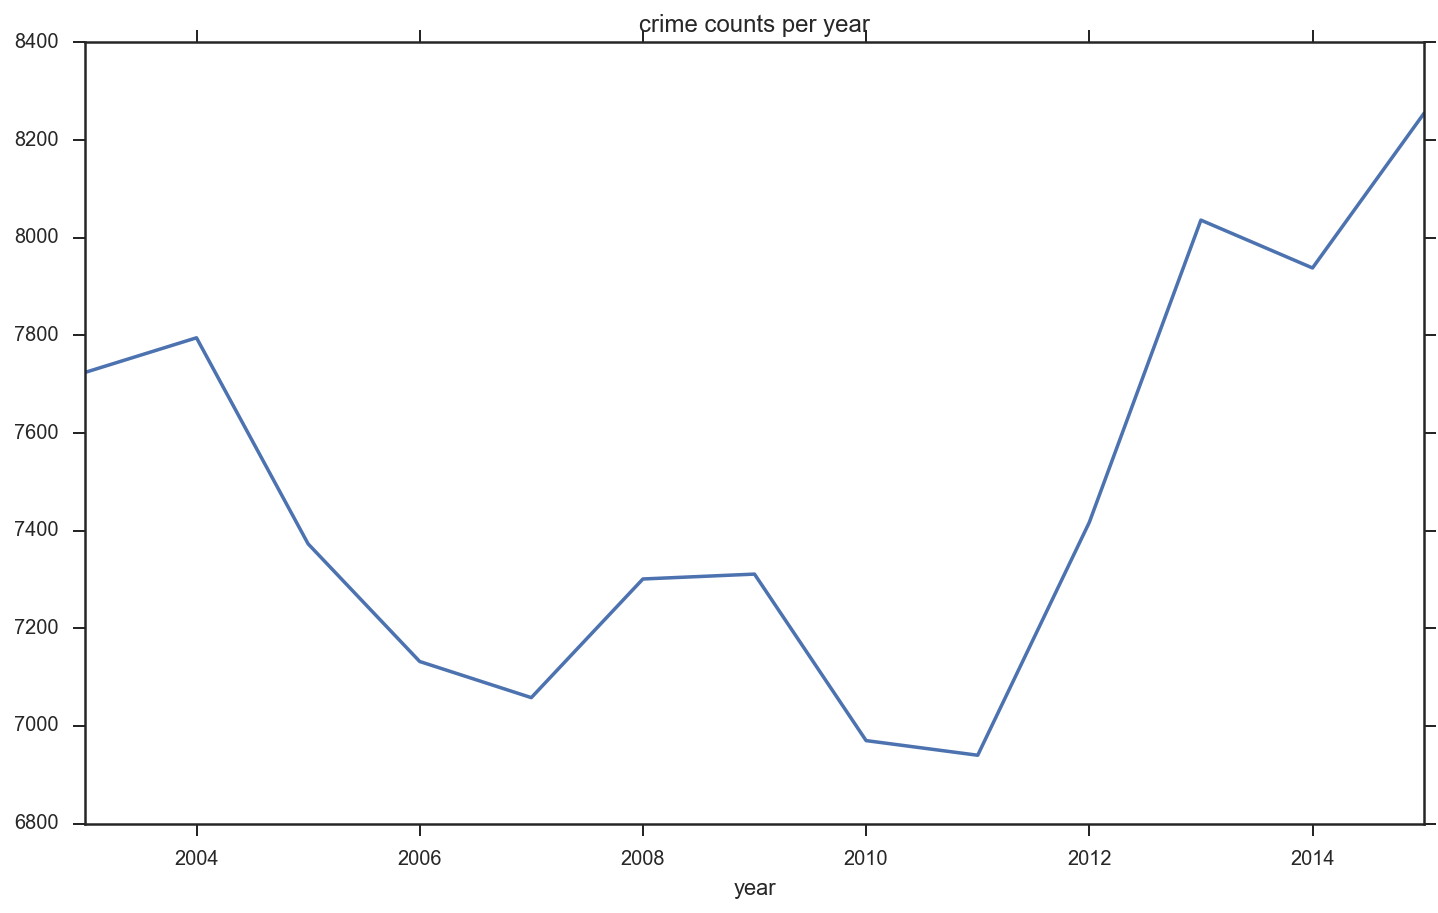

In [626]:
sns.set(rc={"figure.figsize": (12, 7)})
sns.set_style("ticks")
crime_eda.groupby('year').count().Category.plot(title = "crime counts per year")

# programs underfunded and municipal parts were closed down, population rose but number of police on the street actually dropped
# spike of crime, cite some articles that recall when schwarzenegger was governor he got rid of majorit vote rule, a lot of budgets couldn't
# be passed without 3/4 majority vote, most break ins 

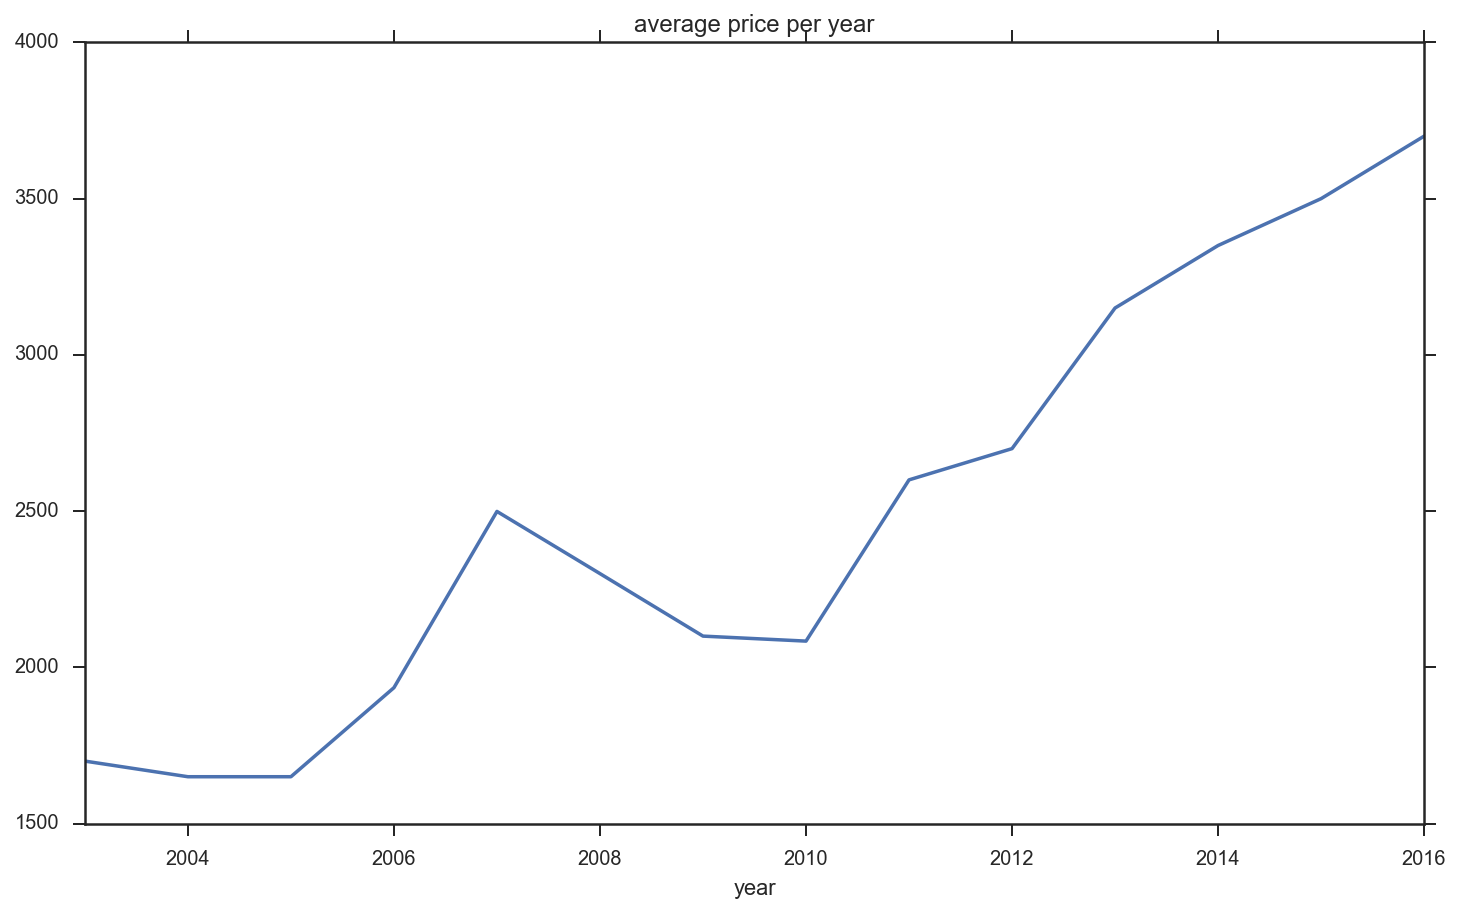

In [709]:

sns.set(rc={"figure.figsize": (12,7)})
sns.set_style("ticks")
#price by year of housing
posts_eda = posts[posts['price']<50000]
posts_eda.groupby('year')['price'].median().plot(title = 'average price per year')

#posts_eda.groupby(['district1','year']).mean().price

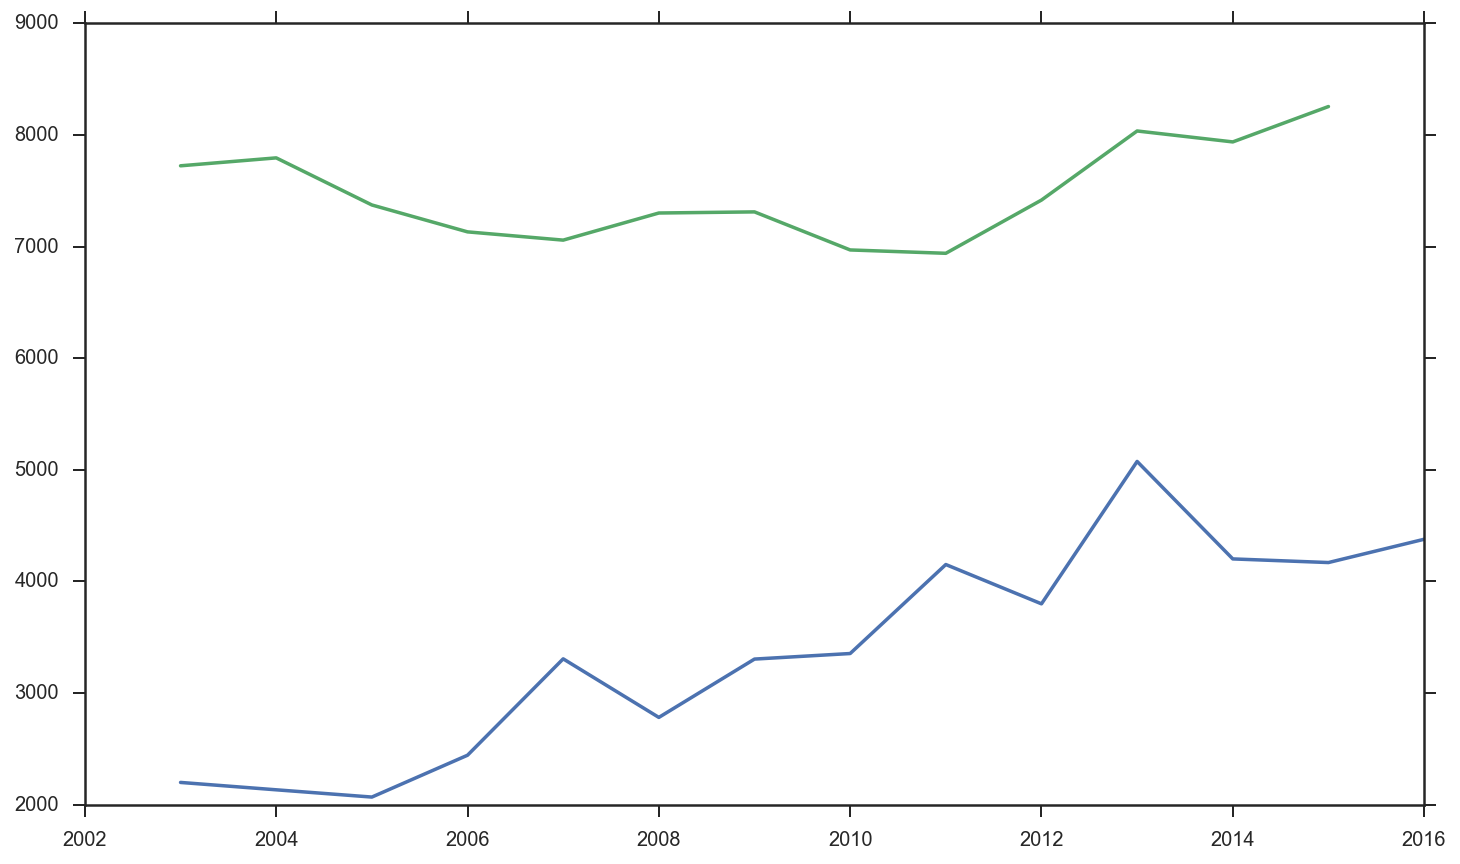

In [637]:
plt.plot(posts_eda.groupby('year')['price'].mean())
plt.plot(crime_eda.groupby('year').count().Category)
plt.show()

In [ ]:
posts_eda.groupby('year')['price'].mean()

In [602]:
del crime_eda['price']

In [391]:
posts_eda1[posts_eda1.district1 == 'south of market']

,year,district1,price
12,2005,south of market,2000.0
17,2006,south of market,2350.0
22,2007,south of market,1900.0
47,2013,south of market,4842.0
52,2014,south of market,4400.0
57,2015,south of market,4340.0
62,2016,south of market,4644.5


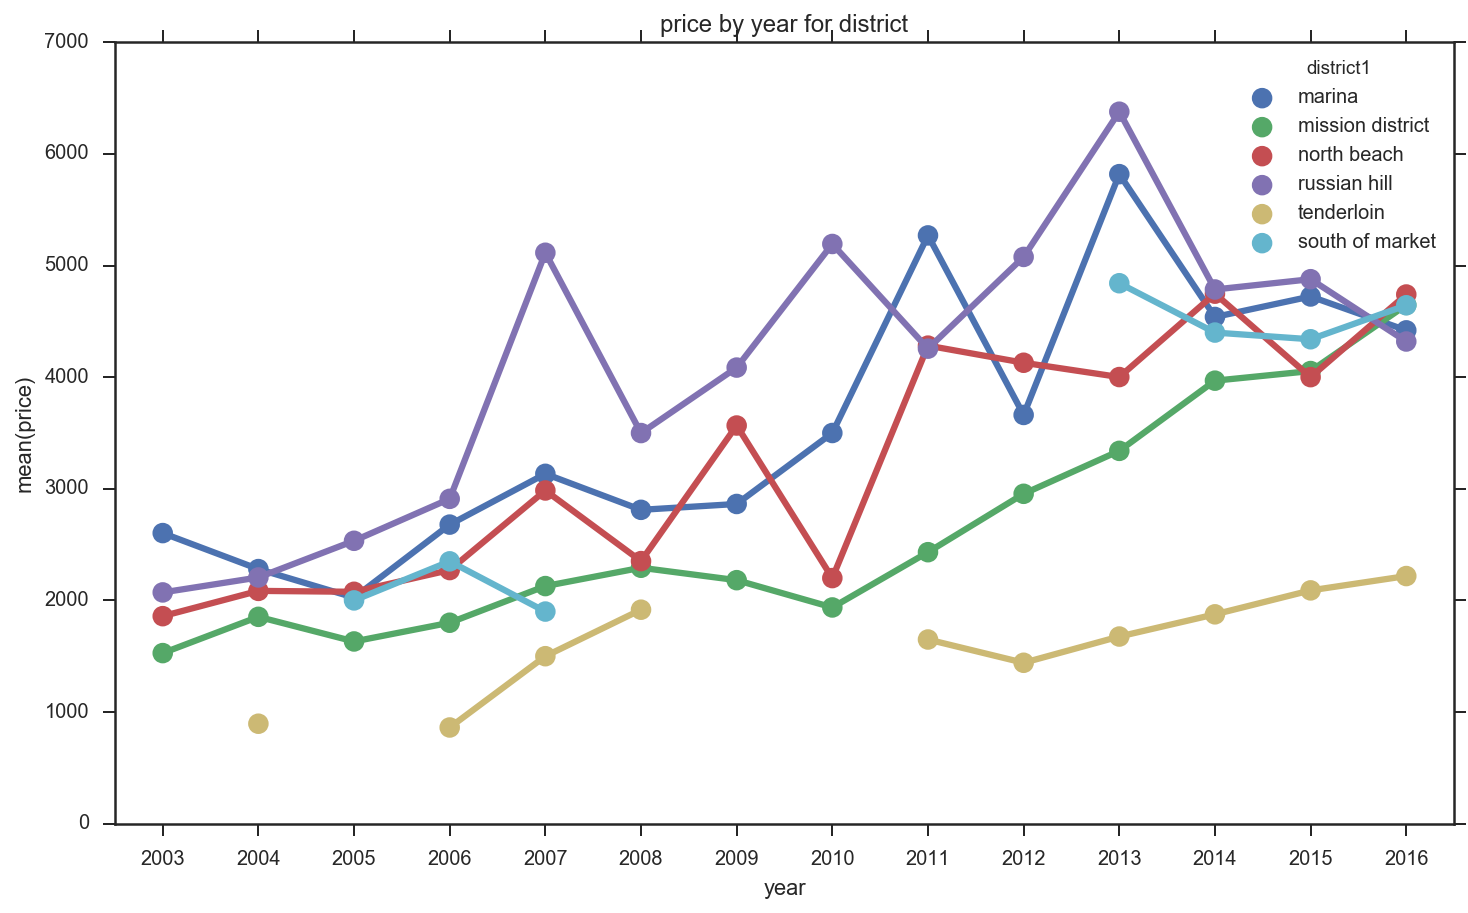

In [636]:
# average price by district
sns.set(rc={"figure.figsize": (12, 7)})
sns.set_style("ticks")
posts_eda = posts_eda[posts_eda.district1.isin(['mission district','south of market','marina','russian hill','north beach','tenderloin']) == True]
posts_eda1 = pd.DataFrame(posts_eda.groupby(['year','district1']).mean()).reset_index()
posts_eda1.drop('bed',axis = 1,inplace = True)

g = sns.pointplot(x = 'year',y= 'price',data = posts_eda1,hue = 'district1')
g.axes.set_title('price by year for district')

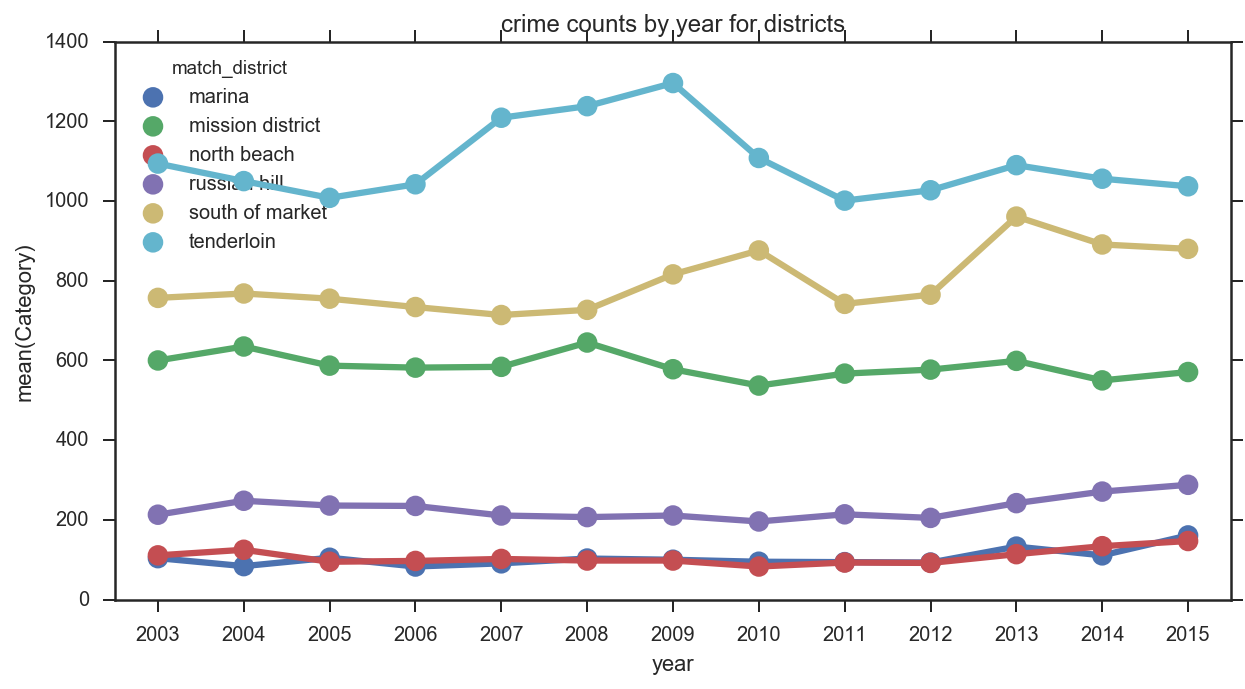

In [463]:
#total crimes per year by district
sns.set(rc={"figure.figsize": (10, 5)})

sns.set_style("ticks")
crime_sub_eda = crime_sub[crime_sub.match_district.isin(['mission district','south of market','marina','russian hill','north beach','tenderloin']) == True]
crime_sub_eda1 = pd.DataFrame(crime_sub_eda.groupby(['year','match_district']).count()['Category']).reset_index()
g = sns.pointplot(x = 'year',y= 'Category',data = crime_sub_eda1,hue = 'match_district')
g.axes.set_title('crime counts by year for districts')

In [340]:
crime_sub_eda1.Category.sum()

24049

In [341]:
crime_sub[crime_sub.is_theft == 1].groupby('year')['is_theft'].sum()

year
2003    2723
2004    2787
2005    2815
2006    2464
2007    2247
2008    2297
2009    2162
2010    2082
2011    2100
2012    2659
2013    2937
2014    2916
2015    3160
2016    1040
Name: is_theft, dtype: int64

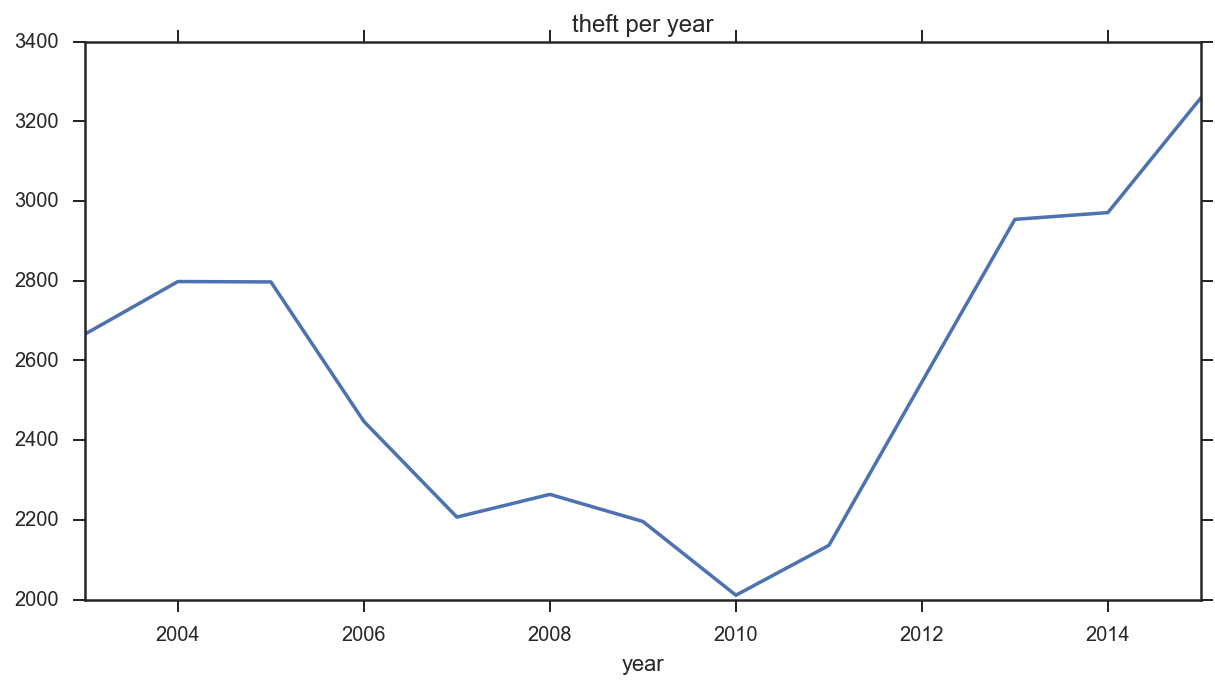

In [468]:
sns.set(rc={"figure.figsize": (10, 5)})
sns.set_style("ticks")
crime_sub[crime_sub.is_theft == 1].groupby('year')['is_theft'].sum()[0:13].plot(title="theft per year")

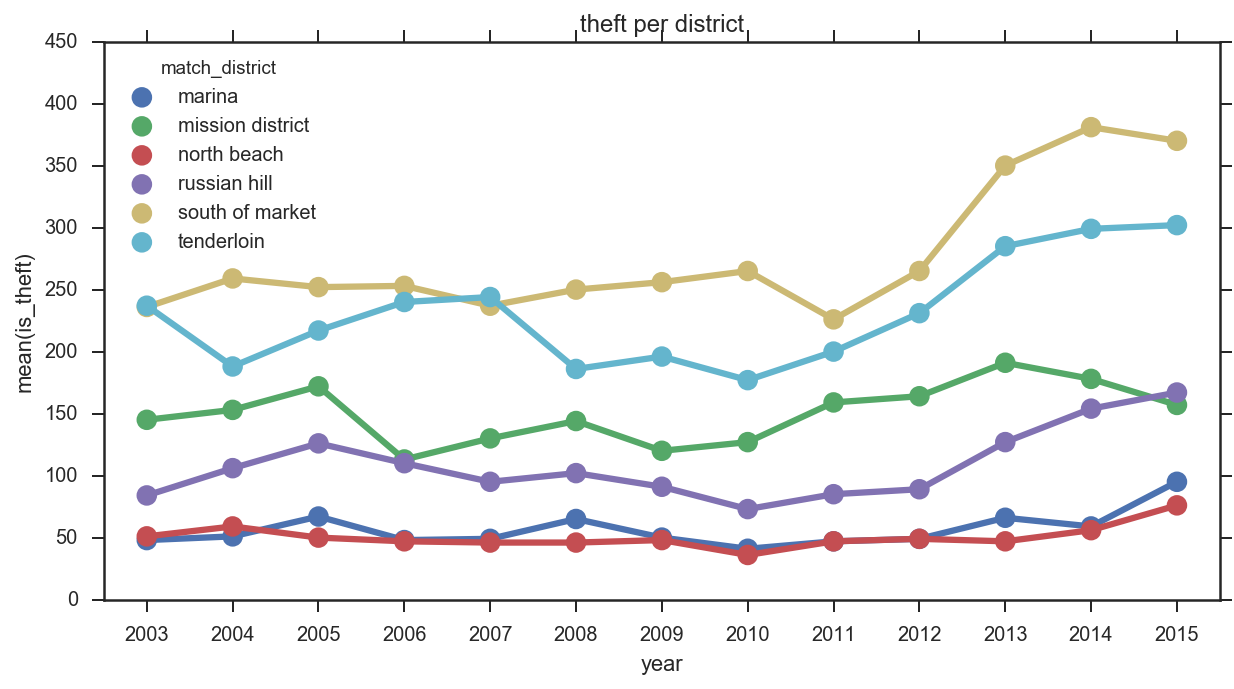

In [469]:
sns.set_style('ticks')
crime_sub_eda = crime_sub[crime_sub['is_theft'] == 1]
crime_sub_eda = crime_sub_eda[crime_sub_eda.match_district.isin(['mission district','south of market','marina','russian hill','north beach','tenderloin']) == True]
crime_sub_eda1 = pd.DataFrame(crime_sub_eda.groupby(['year','match_district']).count()['is_theft']).reset_index()
g = sns.pointplot(x = 'year',y= 'is_theft',data = crime_sub_eda1,hue = 'match_district')
g.axes.set_title("theft per district")

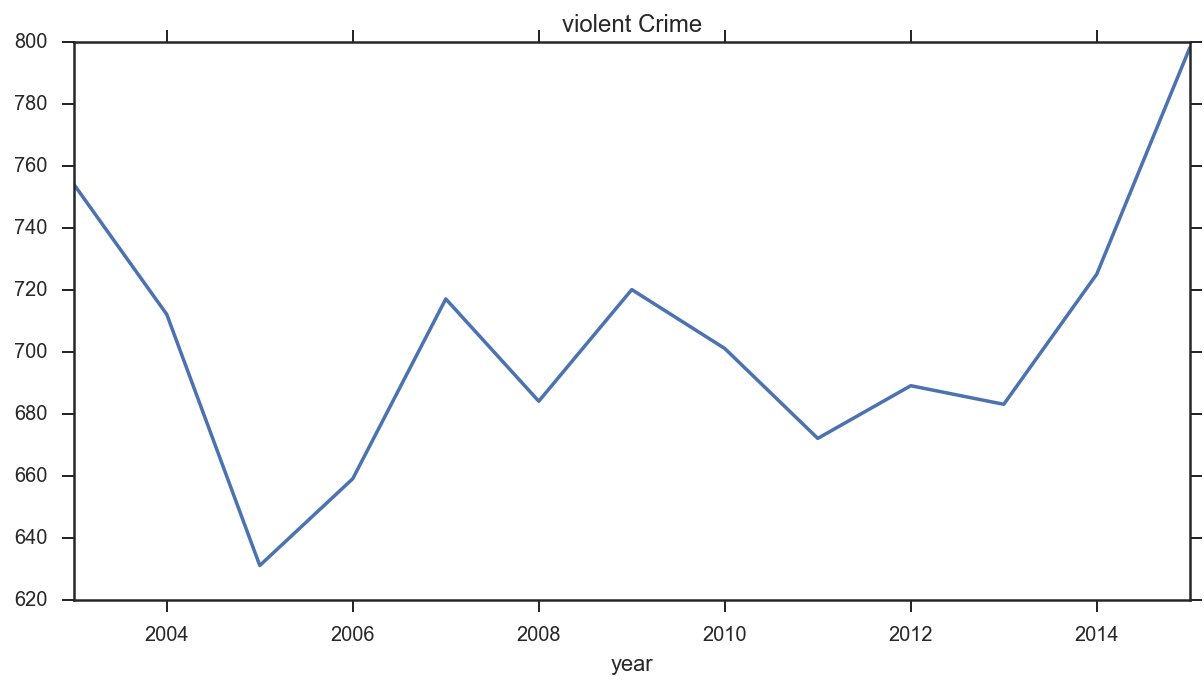

In [475]:
sns.set(rc={"figure.figsize": (10, 5)})
sns.set_style("ticks")
crime_sub[crime_sub.is_violent == 1].groupby('year')['is_violent'].sum()[0:13].plot(title = "violent Crime")


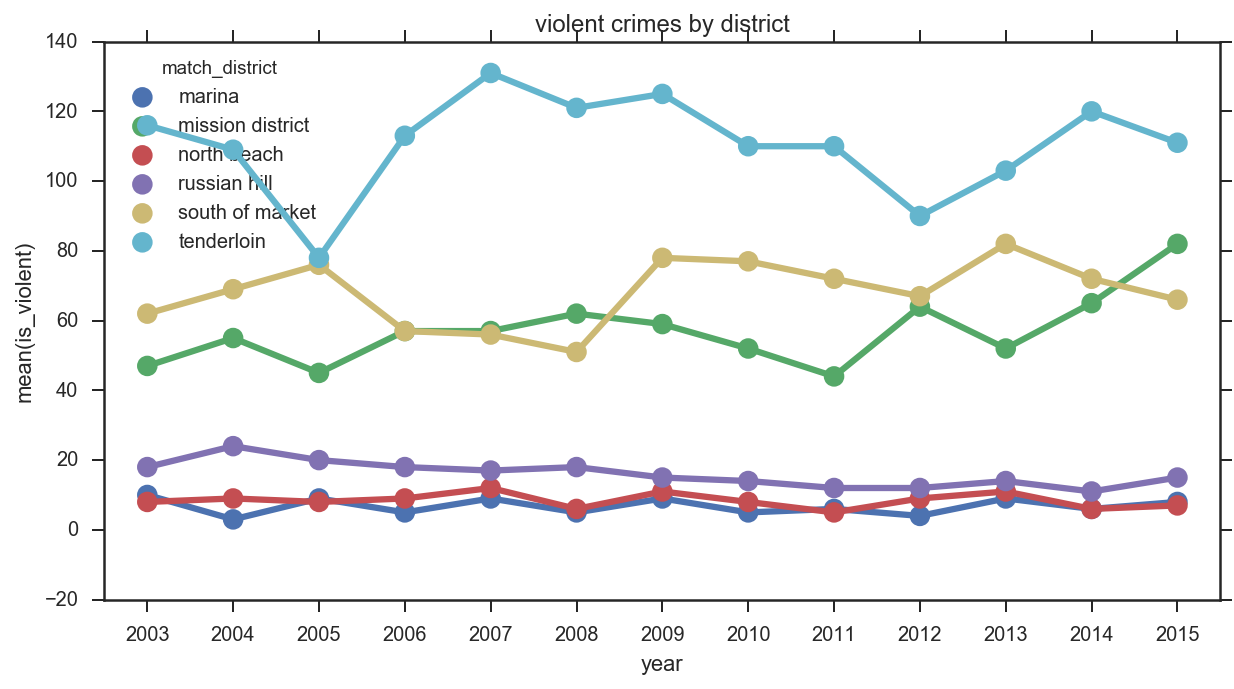

In [459]:
sns.set_style('ticks')
crime_sub_eda = crime_sub[crime_sub['is_violent'] == 1]
crime_sub_eda = crime_sub_eda[crime_sub_eda.match_district.isin(['mission district','south of market','marina','russian hill','north beach','tenderloin']) == True]
crime_sub_eda1 = pd.DataFrame(crime_sub_eda.groupby(['year','match_district']).count()['is_violent']).reset_index()
g = sns.pointplot(x = 'year',y= 'is_violent',data = crime_sub_eda1,hue = 'match_district')
g.axes.set_title('violent crimes by district')

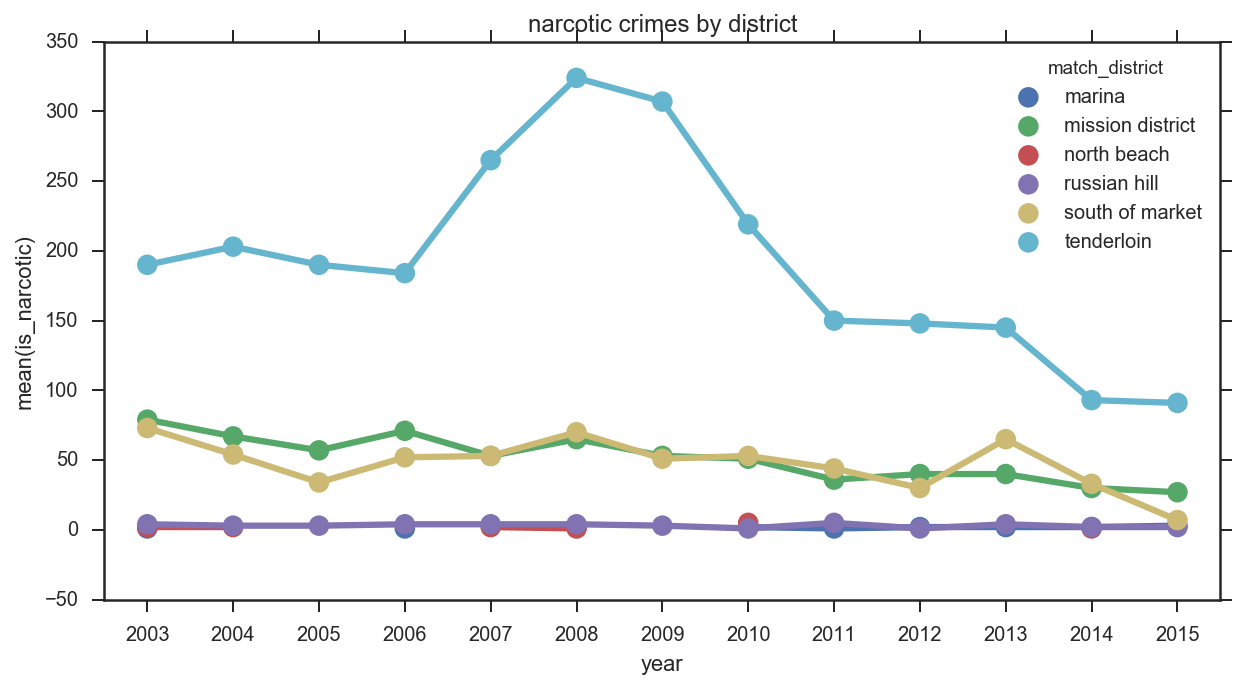

In [458]:
sns.set_style('ticks')
crime_sub_eda = crime_sub[crime_sub['is_narcotic'] == 1]
crime_sub_eda = crime_sub_eda[crime_sub_eda.match_district.isin(['mission district','south of market','marina','russian hill','north beach','tenderloin']) == True]
crime_sub_eda1 = pd.DataFrame(crime_sub_eda.groupby(['year','match_district']).count()['is_narcotic']).reset_index()
g = sns.pointplot(x = 'year',y= 'is_narcotic',data = crime_sub_eda1,hue = 'match_district')
g.axes.set_title('narcotic crimes by district')

LARCENY/THEFT     20580
OTHER OFFENSES    14072
NON-CRIMINAL      10622
ASSAULT            8700
VEHICLE THEFT      6062
DRUG/NARCOTIC      5963
VANDALISM          5075
WARRANTS           4665
BURGLARY           4241
SUSPICIOUS OCC     3581
Name: Category, dtype: int64


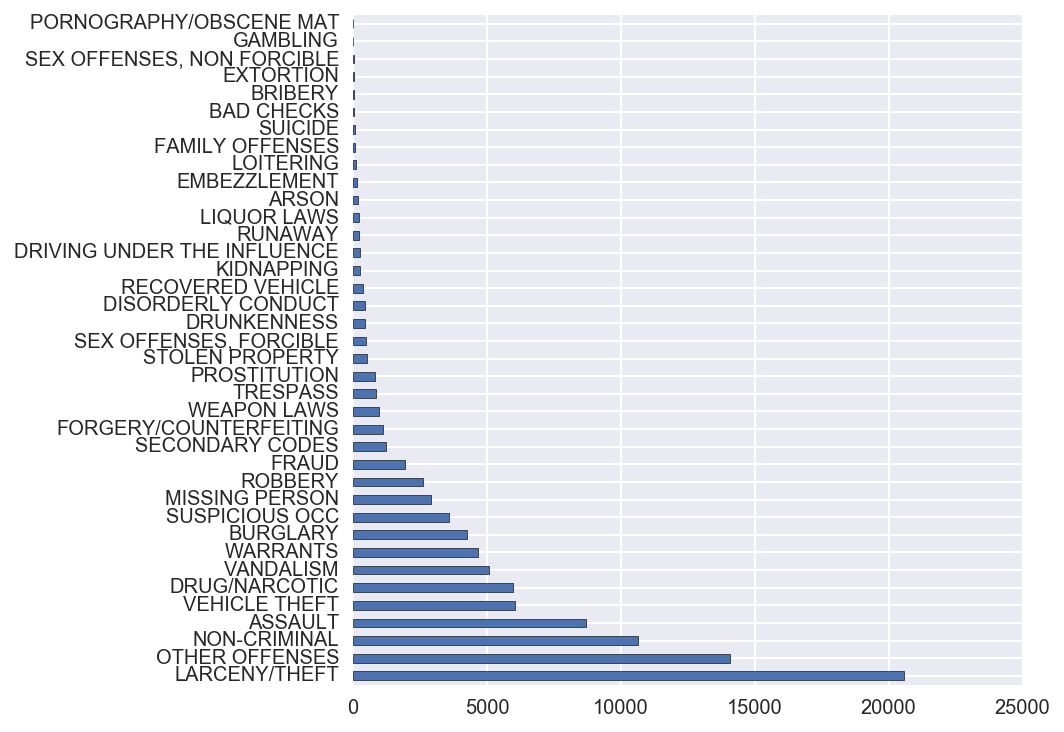

In [23]:
sns.set(rc={"figure.figsize": (6, 6)})

print crime_sub.Category.value_counts()[0:10]
crime_sub.Category.value_counts().plot(kind = 'barh')

# violent_crimes = ['ASSAULT','SEX OFFENSES FORCIBLE','KIDNAPPING','ARSON']
# theft_crimes = ['LARCENY/THEFT','VEHICLE THEFT','BURGLARY','ROBBERY',]
# narcotics = []

In [470]:
crime_sub.Resolution.value_counts()

NONE                                      59136
ARREST, BOOKED                            22782
ARREST, CITED                              8072
LOCATED                                    1799
PSYCHOPATHIC CASE                          1449
UNFOUNDED                                  1096
JUVENILE BOOKED                             610
COMPLAINANT REFUSES TO PROSECUTE            434
NOT PROSECUTED                              421
DISTRICT ATTORNEY REFUSES TO PROSECUTE      386
JUVENILE CITED                              344
PROSECUTED BY OUTSIDE AGENCY                272
JUVENILE ADMONISHED                         194
EXCEPTIONAL CLEARANCE                       181
CLEARED-CONTACT JUVENILE FOR MORE INFO       36
JUVENILE DIVERTED                            35
PROSECUTED FOR LESSER OFFENSE                 3
Name: Resolution, dtype: int64

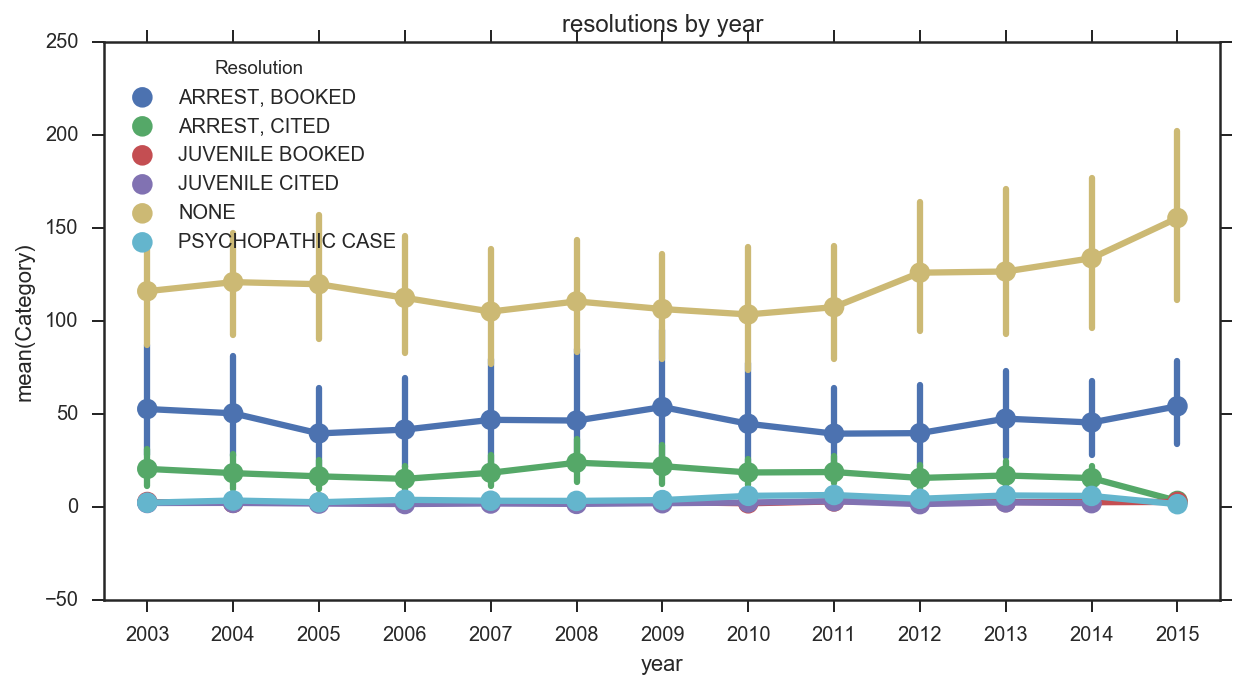

In [471]:

crime_eda = pd.DataFrame(crime_sub.groupby(['year','Resolution','match_district']).count().Category).reset_index()
crime_eda = crime_eda[crime_eda.Resolution.isin(['ARREST, BOOKED','ARREST, CITED','PSYCHOPATHIC CASE','JUVENILE BOOKED','JUVENILE CITED','NONE'])]

g = sns.pointplot(x = 'year',y= 'Category',data = crime_eda,hue = 'Resolution')
g.axes.set_title('resolutions by year')

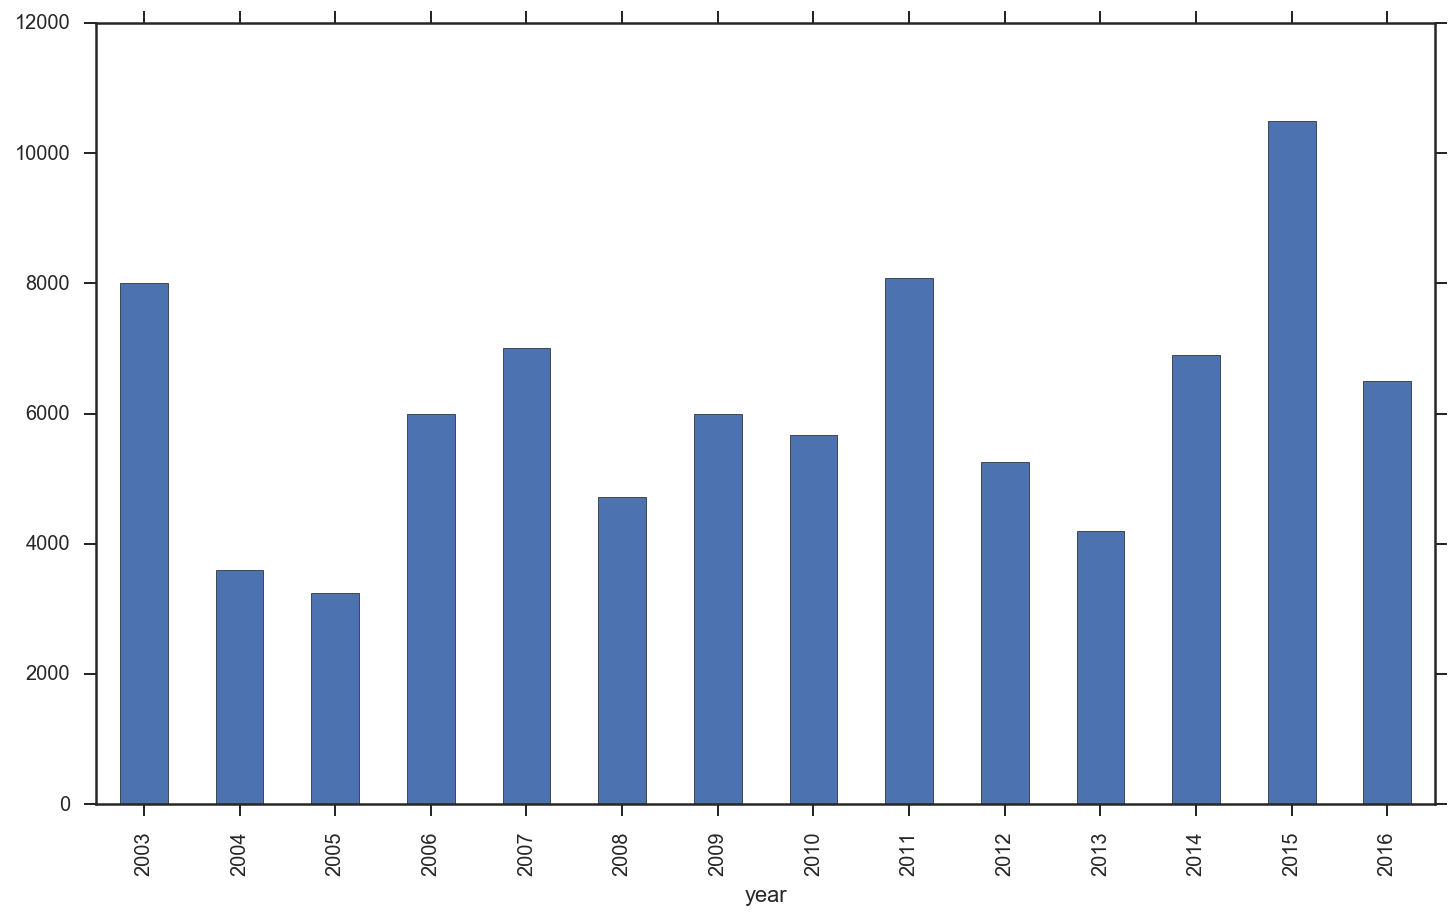

In [716]:
posts[posts.bed == 5].groupby('year').median().price.plot(kind = 'bar')

In [945]:
posts.groupby(['year','bed']).count().head()

Unnamed: 0  post  price  district1  district2  district3
year bed                                                          
2003 0            71    71     71         65         65         65
     1           165   165    165        154        154        151
     2           172   172    172        159        159        159
     3            65    65     65         58         58         58
     4            17    17     17         15         15         15

# transformations

In [25]:
crime_groups = pd.DataFrame(crime_sub.groupby(['year','Category','match_district']).size())

In [26]:
crime_wide = crime_groups.reset_index()
crime_wide.head()

,year,Category,match_district,0
0,2003,ARSON,castro,1
1,2003,ARSON,lower haight,1
2,2003,ARSON,portola,1
3,2003,ARSON,potrero hill,5
4,2003,ARSON,south beach,1


In [27]:
crime_wide.columns = ['year','crime','district','crime_count']
crime_wide.head()

,year,crime,district,crime_count
0,2003,ARSON,castro,1
1,2003,ARSON,lower haight,1
2,2003,ARSON,portola,1
3,2003,ARSON,potrero hill,5
4,2003,ARSON,south beach,1


In [28]:
print [x for x in crime_wide.district.values if not type(x) == str]

[]


In [29]:
crime_wide = crime_wide[[True if type(x) == str else False for x in crime_wide.district.values]]

In [30]:
crime_wide.district = crime_wide.district.map(lambda x: x.lower())
crime_wide_ = pd.pivot_table(crime_wide, index=['year','crime'], columns=['district'], fill_value=0)['crime_count'].reset_index()
crime_wide_.head()

district,year,crime,bernal heights,castro,chinatown,excelsior,financial district,glen park,golden gate park,haight ashbury,...,seacliff,south beach,south of market,sunset,tenderloin,treasure island,twin peaks,usf,visitacion valley,western addition
0,2003,ARSON,0,1,0,0,0,0,0,0,...,0,1,1,2,0,0,0,0,6,0
1,2003,ASSAULT,25,10,28,22,19,12,5,6,...,1,12,63,9,102,3,8,10,53,22
2,2003,BAD CHECKS,0,0,0,0,0,1,0,0,...,0,0,2,0,0,0,0,1,1,1
3,2003,BURGLARY,8,5,16,4,18,5,5,4,...,0,5,13,5,23,0,3,5,19,20
4,2003,DISORDERLY CONDUCT,1,0,5,0,1,0,1,0,...,1,1,5,0,10,0,0,0,0,2


In [31]:
crime_wide_.shape

(500, 41)

In [32]:
crime_trans = crime_wide.T

In [33]:
crime_trans.head()

,0,1,2,3,4,5,6,7,8,9,...,10047,10048,10049,10050,10051,10052,10053,10054,10055,10056
year,2003,2003,2003,2003,2003,2003,2003,2003,2003,2003,...,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016
crime,ARSON,ARSON,ARSON,ARSON,ARSON,ARSON,ARSON,ARSON,ASSAULT,ASSAULT,...,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS
district,castro,lower haight,portola,potrero hill,south beach,south of market,sunset,visitacion valley,bernal heights,castro,...,hayes valley,ingleside,mission district,parkside,potrero hill,south beach,south of market,tenderloin,usf,visitacion valley
crime_count,1,1,1,5,1,1,2,6,25,10,...,1,1,2,3,2,1,1,4,1,1


In [34]:
posts = posts.iloc[:,1:]
posts.head()

,post,year,price,bed,district1,district2,district3
0,950 1br sunny one bedroom for rent sunset p...,2003,950.0,1,sunset,parkside,inner sunset
1,1500 2br 1 ba cow hollow open house thursday...,2003,1500.0,2,marina,nob hill,nob hill
2,1795 2br spacious completely remodeled 2 bd...,2003,1795.0,2,hayes valley,noe valley,visitacion valley
3,1180 0br victorian hotel room wprivate bath ...,2003,1180.0,0,pacific heights,presidio heights,inner richmond
4,1100 1br great landlordgreat tenats inner ri...,2003,1100.0,1,inner richmond,outer richmond,inner sunset


In [35]:
crime_trans.columns = np.ravel(crime_trans.ix['crime',:].values)
crime_trans.head()

,ARSON,ARSON,ARSON,ARSON,ARSON,ARSON,ARSON,ARSON,ASSAULT,ASSAULT,...,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS
year,2003,2003,2003,2003,2003,2003,2003,2003,2003,2003,...,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016
crime,ARSON,ARSON,ARSON,ARSON,ARSON,ARSON,ARSON,ARSON,ASSAULT,ASSAULT,...,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS,WEAPON LAWS
district,castro,lower haight,portola,potrero hill,south beach,south of market,sunset,visitacion valley,bernal heights,castro,...,hayes valley,ingleside,mission district,parkside,potrero hill,south beach,south of market,tenderloin,usf,visitacion valley
crime_count,1,1,1,5,1,1,2,6,25,10,...,1,1,2,3,2,1,1,4,1,1


In [36]:
crime_trans.loc['year',:].values

array([2003, 2003, 2003, ..., 2016, 2016, 2016], dtype=object)

In [37]:
small_posts = posts

In [38]:
small_posts.shape

(39909, 7)

In [344]:
small_posts.year.value_counts()

2005    15456
2004     6434
2006     4530
2016     2499
2012     2289
2014     2230
2015     2035
2011     1486
2007      890
2013      782
2003      497
2008      487
2009      195
2010       99
Name: year, dtype: int64

In [39]:


new_dfs = []

for i, row in small_posts.iterrows():
    
    ndf = pd.DataFrame({
            'post':[row.post],
            'year':[row.year],
            'price':[row.price],
            'bed':[row.bed],
            'district1':[row.district1],
            'district2':[row.district2],
            'district3':[row.district3]
        })
    ndf.index = [i]
    
    d1_mask_colmask = (crime_trans.loc['year',:] == row.year) & (crime_trans.loc['district',:] == row.district1)
    d2_mask_colmask = (crime_trans.loc['year',:] == row.year) & (crime_trans.loc['district',:] == row.district2)
    d3_mask_colmask = (crime_trans.loc['year',:] == row.year) & (crime_trans.loc['district',:] == row.district3)
    
    district1_crimes = crime_trans.ix[['crime_count'], d1_mask_colmask]
    district2_crimes = crime_trans.ix[['crime_count'], d2_mask_colmask]
    district3_crimes = crime_trans.ix[['crime_count'], d3_mask_colmask]
    
    district1_crimes.columns = ['D1_'+x for x in district1_crimes.columns]
    district2_crimes.columns = ['D2_'+x for x in district2_crimes.columns]
    district3_crimes.columns = ['D3_'+x for x in district3_crimes.columns]
    
    dist_crimes = pd.concat([district1_crimes, district2_crimes, district3_crimes],
                            axis=1, ignore_index=False)
    
    
    dist_crimes.index = [i]
    
    ndf = pd.concat([ndf, dist_crimes], axis=1, ignore_index=False)
    
    new_dfs.append(ndf)
    
posts_crimes = pd.concat(new_dfs, axis=0, ignore_index=False).fillna(value=0, axis=1)
    
    
    
    

In [40]:
posts_crimes.shape

(39909, 121)

In [41]:
from sklearn.preprocessing import LabelEncoder


In [42]:
posts_crimes.district1 = posts_crimes.district1.map(lambda x: 'none' if x == 0 else x)
posts_crimes.district2 = posts_crimes.district2.map(lambda x: 'none' if x == 0 else x)
posts_crimes.district3 = posts_crimes.district3.map(lambda x: 'none' if x == 0 else x)

In [43]:
label_encoder = LabelEncoder()

dists = posts_crimes.district1.values.tolist() + posts_crimes.district2.values.tolist() + posts_crimes.district3.values.tolist()
dists = np.unique(dists)
# print dists
# print posts_crimes.district1.unique()
# print posts_crimes.district2.unique()
# print posts_crimes.district3.unique()


label_encoder.fit(dists)

posts_crimes['district1_code'] = label_encoder.transform(posts_crimes.district1.values)
posts_crimes['district2_code'] = label_encoder.transform(posts_crimes.district2.values)
posts_crimes['district3_code'] = label_encoder.transform(posts_crimes.district3.values)

In [44]:
posts_crimes.shape

(39909, 124)

In [45]:
district1_prices = pd.DataFrame(posts_crimes.groupby(['district1']).price.mean())

In [46]:
print district1_prices.shape, district_coordinates.shape

(48, 1) (41, 3)


In [47]:
district1_prices = pd.DataFrame(posts_crimes.groupby(['district1']).price.mean())
district1_prices.reset_index(inplace = True)
district1_prices = district1_prices.rename(columns  = { 'district1' : 'district'})

In [48]:
district1_prices.head()

,district,price
0,bernal heights,3577.441423
1,castro,2133.529412
2,chinatown,1185.000000
3,downtown,1560.542295
4,excelsior,1334.375000


In [49]:
choro = district1_prices.merge(district_coordinates)

In [50]:
choro.to_csv('/Users/Stav/Downloads/choro.csv')

In [51]:
neighbors = neighbors.rename(columns  = { 'neighborhoods' : 'district'})

In [52]:
del geom_polys['index']

KeyError: 'index'

In [53]:
neighbors.district = neighbors.district.apply(lambda x: x.lower())

In [54]:
neighbors.merge(choro).to_csv('/Users/Stav/Downloads/neighbors_price_merge.csv')

In [55]:
geom_polys = geom_polys.reset_index()

In [56]:
geom_polys.columns = ['district','geom']
geom_polys.district = geom_polys.district.apply(lambda x: x.lower())

In [57]:
geom_price = choro.merge(geom_polys)

In [58]:
from shapely.geometry import MultiPoint
geom_price.geom = geom_price.geom.apply(lambda x: MultiPoint(x).convex_hull)

In [59]:
geom_price.to_csv('/Users/Stav/Downloads/geom_price.csv')

In [60]:
geom_price.head()

,district,price,lat,lon,geom
0,bernal heights,3577.441423,37.7412,-122.4178,"POLYGON ((-122.422969 37.731461, -122.425231 3..."
1,chinatown,1185.000000,37.7941,-122.4078,"POLYGON ((-122.478282 37.786864, -122.478735 3..."
2,excelsior,1334.375000,37.7244,-122.4272,"POLYGON ((-122.433579 37.713076, -122.437606 3..."
3,financial district,4084.378661,37.7946,-122.3999,"POLYGON ((-122.401146 37.781999, -122.406223 3..."
4,glen park,2330.138568,37.7378,-122.4321,"POLYGON ((-122.432493 37.733201, -122.43841 37..."


In [61]:
import folium
from folium import plugins
map_osm = folium.Map(location=[37.7599,-122.431297],tiles='cartodb dark_matter', zoom_start = 12)

map_osm.geo_json('./planning_neighborhoods.geojson', fill_color='none',line_color='steelblue',line_weight=3)


map_osm.create_map(path='osm.html')

#map_osm

/Users/Stav/anaconda/lib/python2.7/site-packages/folium/folium.py:504: UserWarning: This method is deprecated. Please use Map.choropleth instead.
  warnings.warn('This method is deprecated. '
/Users/Stav/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: Map.create_map is deprecated. Use Map.save instead


In [62]:
posts_crimes.head(2)

,D1_ARSON,D1_ASSAULT,D1_BAD CHECKS,D1_BRIBERY,D1_BURGLARY,D1_DISORDERLY CONDUCT,D1_DRIVING UNDER THE INFLUENCE,D1_DRUG/NARCOTIC,D1_DRUNKENNESS,D1_EMBEZZLEMENT,...,bed,district1,district2,district3,post,price,year,district1_code,district2_code,district3_code
0,2,9,0,0,5,0,0,1,0,0,...,1,sunset,parkside,inner sunset,950 1br sunny one bedroom for rent sunset p...,950.0,2003,45,36,13
1,0,3,0,0,9,0,1,2,0,1,...,2,marina,nob hill,nob hill,1500 2br 1 ba cow hollow open house thursday...,1500.0,2003,20,26,26


In [63]:
posts_crimes[['district1_code','bed','year']].head()

,district1_code,bed,year
0,45,1,2003
1,20,2,2003
2,10,2,2003
3,33,0,2003
4,12,1,2003


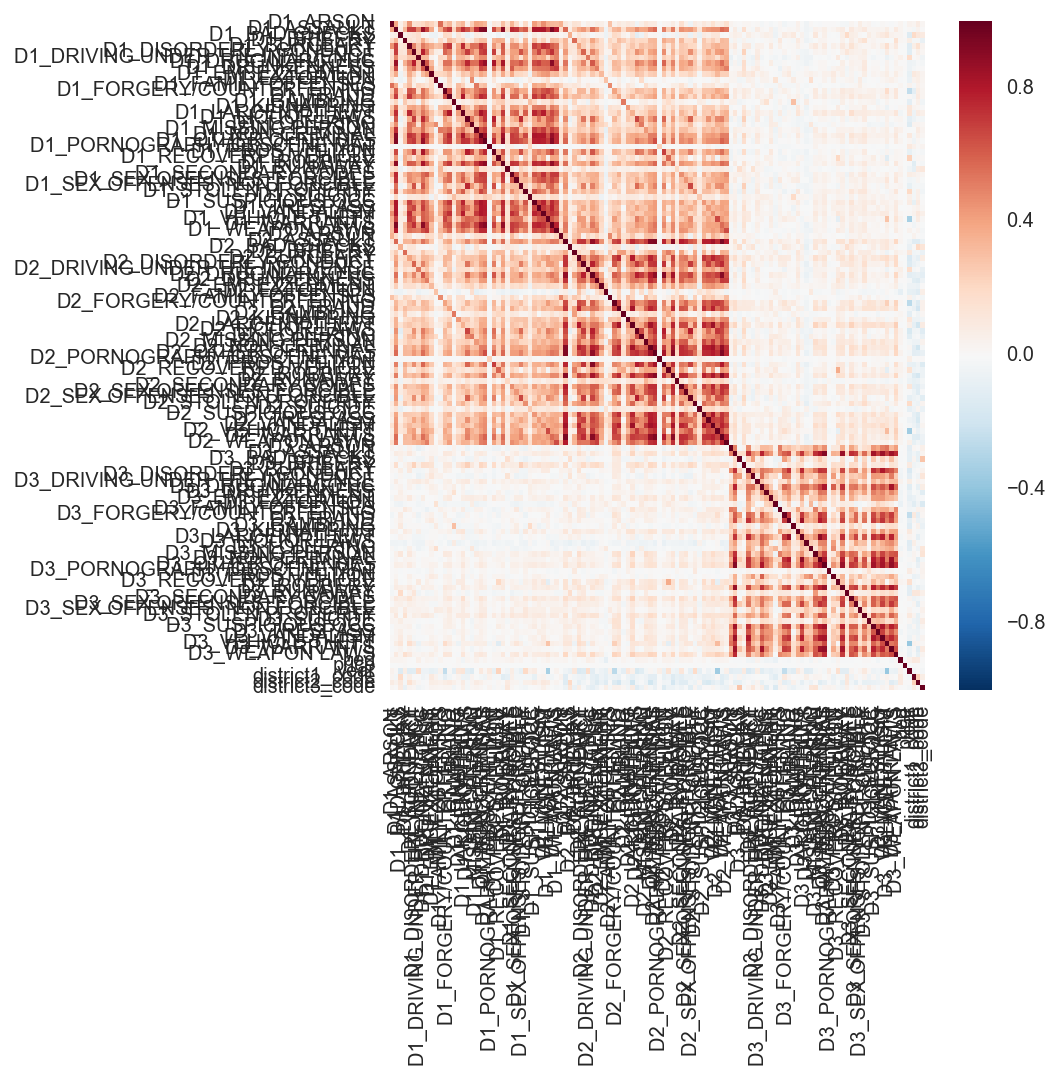

In [64]:
sns.heatmap(posts_crimes.corr())

In [69]:
posts_crimes.dtypes.head()

D1_ARSON         int64
D1_ASSAULT       int64
D1_BAD CHECKS    int64
D1_BRIBERY       int64
D1_BURGLARY      int64
dtype: object

In [70]:
posts_crimes = posts_crimes[posts_crimes.price < 50000]

In [476]:
target = posts_crimes.price
tmp = posts_crimes[[col for col in posts_crimes if posts_crimes[col].dtype != object]]

print posts_crimes.post.dtype

#[col for col in posts_crimes if posts_crimes[col].dtype != object]

object


In [477]:
posts_crimes['price'] = target

In [478]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
X = posts_crimes[['district1_code','bed','year']]
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

lm = LinearRegression()

model = lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)
print model.score(X_test, y_test)   # coefficient of r2
print model.score(X_test,y_pred)


0.406321187139
1.0


In [479]:
posts_crimes.dtypes.head()

D1_ARSON         int64
D1_ASSAULT       int64
D1_BAD CHECKS    int64
D1_BRIBERY       int64
D1_BURGLARY      int64
dtype: object

In [480]:
target.head()

0     950.0
1    1500.0
2    1795.0
3    1180.0
4    1100.0
Name: price, dtype: float64

In [481]:
tmp.shape

(39883, 120)

In [482]:
D1 = [c for c in tmp if 'D1' in c ]+['bed','year','district1_code']
tmp[D1].head()

,D1_ARSON,D1_ASSAULT,D1_BAD CHECKS,D1_BRIBERY,D1_BURGLARY,D1_DISORDERLY CONDUCT,D1_DRIVING UNDER THE INFLUENCE,D1_DRUG/NARCOTIC,D1_DRUNKENNESS,D1_EMBEZZLEMENT,...,D1_SUICIDE,D1_SUSPICIOUS OCC,D1_TRESPASS,D1_VANDALISM,D1_VEHICLE THEFT,D1_WARRANTS,D1_WEAPON LAWS,bed,year,district1_code
0,2,9,0,0,5,0,0,1,0,0,...,0,2,0,8,12,1,0,1,2003,45
1,0,3,0,0,9,0,1,2,0,1,...,1,0,0,6,14,0,0,2,2003,20
2,0,44,0,0,16,4,1,23,1,0,...,0,8,5,18,47,36,6,2,2003,10
3,0,4,1,0,11,0,2,1,1,0,...,0,1,1,5,22,3,0,0,2003,33
4,0,11,0,0,6,0,0,4,0,1,...,0,7,0,10,26,3,1,1,2003,12


In [717]:
print tmp[D1].shape, target.shape

(39883, 41) (39883,)


In [718]:
print np.mean(target),np.std(target)

2493.80771256 1893.23521372


In [719]:
print X_test.shape,y_test.shape

(13162, 10) (13162,)


In [720]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(tmp[D1], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


param_grid = {'max_depth': np.arange(3, 10),'min_samples_split':[2,5,10]}

tree = GridSearchCV(DecisionTreeRegressor(criterion='mse'), param_grid, cv = 10,n_jobs = -1)

tree.fit(X_train, y_train)

tree_preds = tree.predict(X_test)
print X_test.shape,y_test.shape


tree_performance = tree.score(X_test, y_test)

print tree_preds
print tree_performance
print tree.best_params_
print tree.grid_scores_
print tree.best_estimator_
print tree.best_score_


(13162, 41) (13162,)
[ 2258.96045198  2588.23136247  2754.71794872 ...,  1664.93103448
  2258.96045198  3653.97560976]
0.588584681655
{'min_samples_split': 10, 'max_depth': 9}
[mean: 0.41129, std: 0.03538, params: {'min_samples_split': 2, 'max_depth': 3}, mean: 0.41129, std: 0.03538, params: {'min_samples_split': 5, 'max_depth': 3}, mean: 0.41129, std: 0.03538, params: {'min_samples_split': 10, 'max_depth': 3}, mean: 0.45075, std: 0.03535, params: {'min_samples_split': 2, 'max_depth': 4}, mean: 0.45075, std: 0.03535, params: {'min_samples_split': 5, 'max_depth': 4}, mean: 0.45075, std: 0.03535, params: {'min_samples_split': 10, 'max_depth': 4}, mean: 0.49035, std: 0.03370, params: {'min_samples_split': 2, 'max_depth': 5}, mean: 0.49390, std: 0.03232, params: {'min_samples_split': 5, 'max_depth': 5}, mean: 0.49695, std: 0.03479, params: {'min_samples_split': 10, 'max_depth': 5}, mean: 0.52085, std: 0.02809, params: {'min_samples_split': 2, 'max_depth': 6}, mean: 0.51954, std: 0.02391, p

In [494]:
# best fit tree regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(tmp[D1], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

tree = DecisionTreeRegressor(criterion='mse', max_depth = 9, min_samples_split = 5)

tree.fit(X_train, y_train)

tree_preds = tree.predict(X_test)
print X_test.shape,y_test.shape


tree_performance = tree.score(X_test, y_test)

print tree_preds
print 'performance r2:',tree_performance
print tree.feature_importances_

features_df = pd.DataFrame([col for col in tmp[D1]],[i for i in tree.feature_importances_]).reset_index()


(13162, 41) (13162,)
[ 2102.33497537  1788.18518519  2866.72860636 ...,  4916.4         5391.45283019
  2536.25316456]
performance r2: 0.584572387127
[  4.71665468e-04   1.21357578e-02   2.44392556e-04   0.00000000e+00
   1.97176538e-02   1.74309371e-08   4.88659040e-04   2.11808475e-03
   2.78006135e-03   3.17549484e-05   2.72914599e-05   2.56506537e-04
   2.75887234e-03   2.83665510e-03   1.48416750e-03   3.48939446e-04
   5.14410326e-02   2.20084245e-03   0.00000000e+00   2.82876749e-02
   6.92852646e-03   5.25863817e-03   0.00000000e+00   2.86018099e-04
   1.96314110e-03   4.37685747e-03   4.59949925e-03   9.30552861e-03
   2.10878908e-03   4.20324504e-04   3.30541748e-03   7.43992640e-05
   1.67087644e-02   2.03571387e-03   4.02542683e-03   2.95485323e-03
   1.23693732e-02   1.85299554e-02   4.27585762e-01   2.98474306e-01
   5.10586764e-02]


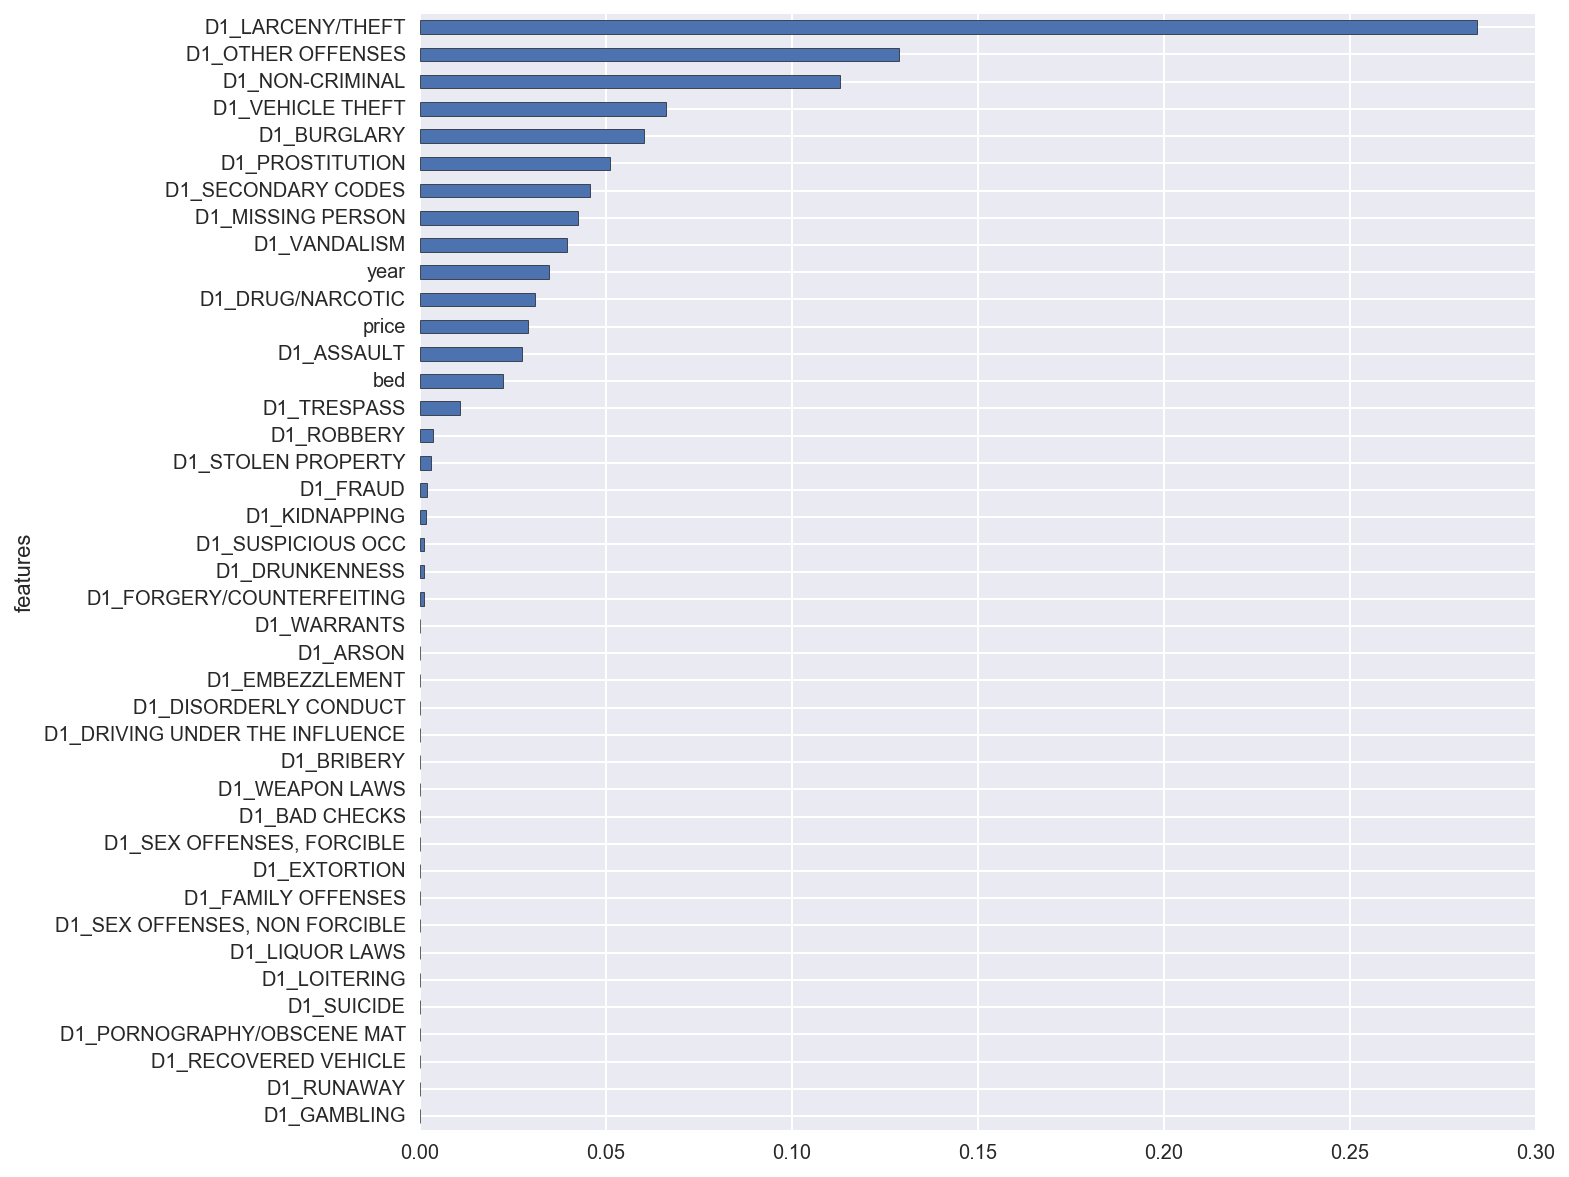

In [756]:
sns.set(rc={"figure.figsize": (10,10)})

features_df.rename(columns = {'index':'score',0:'features'},inplace = True)

features_df.set_index('features').score.sort_values().plot(kind = 'barh')

# 'year','bed','weapon laws',

In [492]:
print tree_preds
print 'performance', tree_performance



[ 4931.61878453  1602.86213992  3719.89177489 ...,  2606.10638298
  1119.50390016  5392.11666667]
performance 0.598607786903


In [87]:
from sklearn.metrics import roc_curve

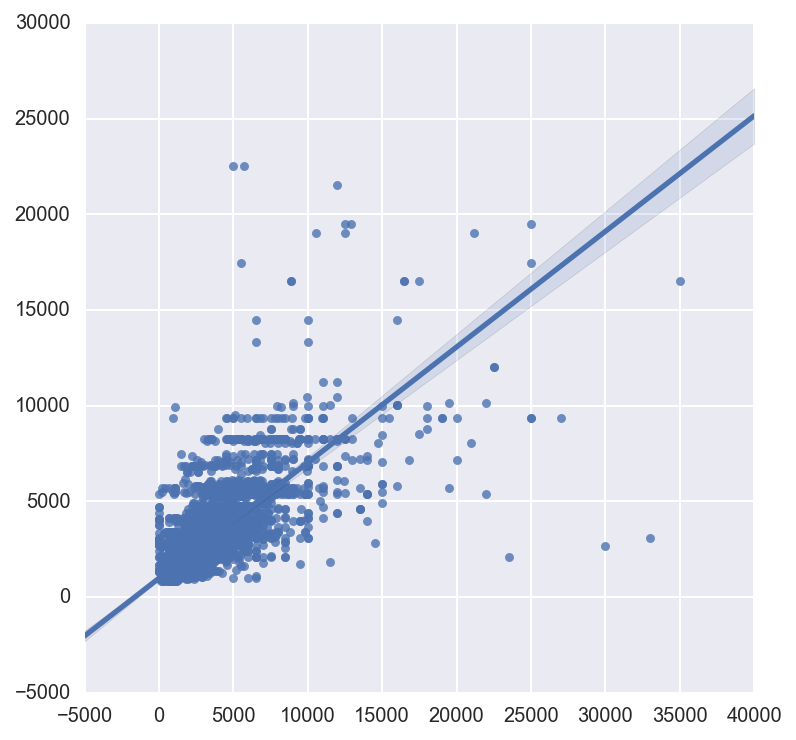

In [495]:
sns.set(rc={"figure.figsize": (6, 6)})
sns.regplot(y_test,tree_preds)

In [656]:
selected_features = [i for i in features_df[features_df.score > .01].features]

In [658]:
tmp[D1][selected_features].head()

,D1_ASSAULT,D1_BURGLARY,D1_LARCENY/THEFT,D1_MISSING PERSON,D1_SUSPICIOUS OCC,D1_WARRANTS,D1_WEAPON LAWS,bed,year,district1_code
0,9,5,8,4,2,1,0,1,2003,45
1,3,9,35,0,0,0,0,2,2003,20
2,44,16,104,12,8,36,6,2,2003,10
3,4,11,20,2,1,3,0,0,2003,33
4,11,6,26,4,7,3,1,1,2003,12


In [671]:
# best fit tree regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(tmp[D1][selected_features], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

tree = DecisionTreeRegressor(criterion='mse', max_depth = 9, min_samples_split = 5)

tree.fit(X_train, y_train)

tree_preds = tree.predict(X_test)
print X_test.shape,y_test.shape

print target[0:3]
tree_performance = tree.score(X_test, y_test)

print tree_preds
print 'performance r2:',tree_performance
print tree.feature_importances_

#eatures_df = pd.DataFrame([col for col in tmp[D1]],[i for i in tree.feature_importances_]).reset_index()

(13162, 10) (13162,)
[  950.  1500.  1795.]
[ 2861.25682382  5198.98136646  1429.33607908 ...,  1905.27749454
  2486.64615385  2162.35757576]
performance r2: 0.583274600991
[ 0.02104464  0.03847225  0.0687892   0.02297157  0.01770861  0.02250704
  0.00698582  0.43475998  0.29160473  0.07515617]


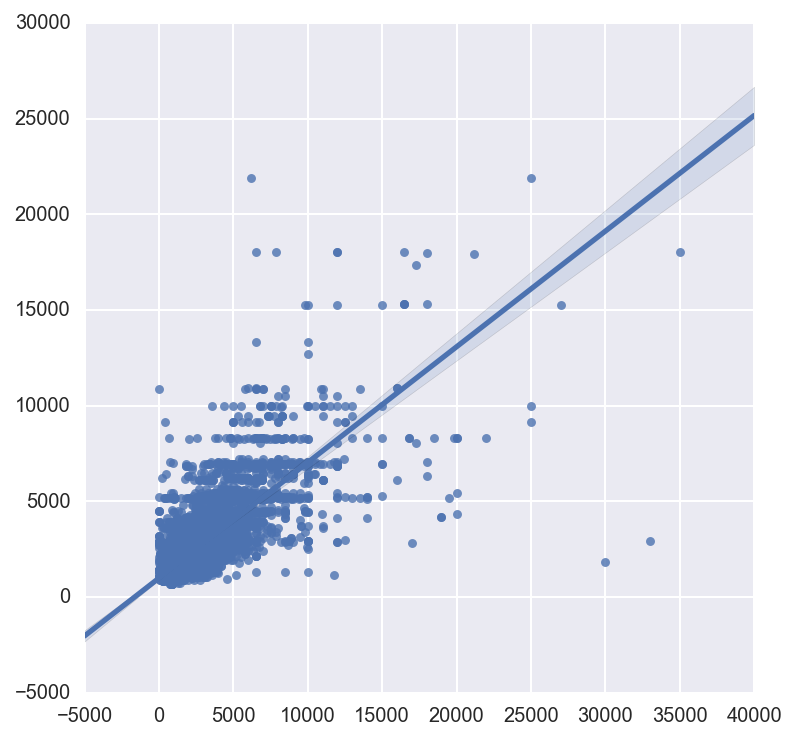

In [672]:
sns.set(rc={"figure.figsize": (6, 6)})
sns.regplot(y_test,tree_preds)

# random forrest regressor

In [760]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

forest = RandomForestRegressor(random_state=0, n_estimators=1000, min_samples_split = 5)



X_train, X_test, y_train, y_test = train_test_split(tmp[D1], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

forest.fit(X_train, y_train)

forest_preds = forest.predict(X_test)

# forest_preds = cross_val_score(estimator = forest, X_test, y= y_test, scoring=None, cv=5, n_jobs=-1, verbose=0, fit_params=None)

forest_performance = forest.score(X_test, y_test)

print forest_preds
print 'forest r2:',forest_performance
print forest
print forest.get_params

[ 6333.05934395  2272.40240088  1254.43195516 ...,  6333.05934395
   882.15279673  2271.03224742]
forest r2: 0.593516829632
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
<bound method RandomForestRegressor.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)>


performance 0.615375293989


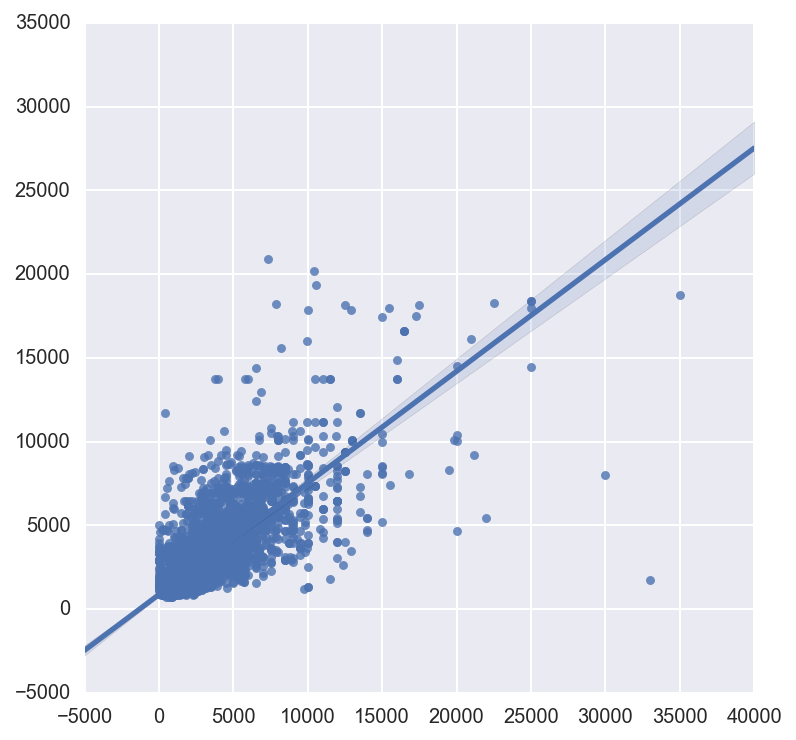

In [474]:
print 'performance', forest_performance
sns.set(rc={"figure.figsize": (6, 6)})
sns.regplot(y_test,forest_preds)

In [721]:
# random forest selected features
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

forest = RandomForestRegressor(random_state=0, n_estimators=1000, min_samples_split = 5)



X_train, X_test, y_train, y_test = train_test_split(tmp[D1][selected_features], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

forest.fit(X_train, y_train)

forest_preds = forest.predict(X_test)

# forest_preds = cross_val_score(estimator = forest, X_test, y= y_test, scoring=None, cv=5, n_jobs=-1, verbose=0, fit_params=None)

forest_performance = forest.score(X_test, y_test)

print forest_preds
print 'forest r2:',forest_performance
print forest
print forest.get_params

[ 1190.20163875  1343.74015126  1606.54172587 ...,  2090.59179822
  1078.8676103   1912.83018653]
forest r2: 0.603335282312
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
<bound method RandomForestRegressor.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)>


In [274]:
tmp[D1].head()

,D1_ARSON,D1_ASSAULT,D1_BAD CHECKS,D1_BRIBERY,D1_BURGLARY,D1_DISORDERLY CONDUCT,D1_DRIVING UNDER THE INFLUENCE,D1_DRUG/NARCOTIC,D1_DRUNKENNESS,D1_EMBEZZLEMENT,...,D1_SUICIDE,D1_SUSPICIOUS OCC,D1_TRESPASS,D1_VANDALISM,D1_VEHICLE THEFT,D1_WARRANTS,D1_WEAPON LAWS,bed,year,district1_code
0,0,9,0,0,4,1,0,1,0,0,...,0,1,0,5,16,0,1,1,2003,45
1,0,9,0,0,10,0,0,0,1,0,...,0,4,1,3,14,4,0,2,2003,20
2,1,54,0,0,19,2,1,32,3,0,...,0,11,4,20,51,30,4,2,2003,10
3,1,3,1,0,6,0,0,0,0,0,...,0,7,0,5,11,4,2,0,2003,33
4,0,20,0,0,6,0,1,2,0,0,...,0,10,2,12,18,7,1,1,2003,12


# Classification Decision Tree

In [722]:
D1_class =  tmp[D1]
D1_target = D1_class.district1_code
del D1_class['district1_code']
D1_class['price'] = target


/Users/Stav/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [725]:
#del D1_class['district_code']
#D1_class

In [726]:


from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(D1_class, D1_target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


param_grid = {'max_depth': np.arange(3, 10)}

tree = GridSearchCV(DecisionTreeClassifier(criterion='gini'), param_grid, cv = 10,n_jobs = -1)

tree.fit(X_train, y_train)

tree_preds = tree.predict(X_test)
print X_test.shape,y_test.shape


tree_performance = tree.score(X_test, y_test)

print tree_preds
print tree_performance
print tree.best_params_


(13162, 41) (13162,)
[ 6 28  4 ..., 11 11 33]
0.710530314542
{'max_depth': 9}


In [727]:
print tree_preds
print 'performance', tree_performance
print tree.grid_scores_
print tree.best_estimator_
print tree.best_score_
#print tree.feature_importances

[ 6 28  4 ..., 11 11 33]
performance 0.710530314542
[mean: 0.34748, std: 0.00526, params: {'max_depth': 3}, mean: 0.40844, std: 0.00488, params: {'max_depth': 4}, mean: 0.47678, std: 0.00559, params: {'max_depth': 5}, mean: 0.52517, std: 0.00678, params: {'max_depth': 6}, mean: 0.58123, std: 0.00817, params: {'max_depth': 7}, mean: 0.65334, std: 0.00564, params: {'max_depth': 8}, mean: 0.70173, std: 0.00596, params: {'max_depth': 9}]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.701732719584


In [728]:
D1_target.head()

0    45
1    20
2    10
3    33
4    12
Name: district1_code, dtype: int64

In [744]:
# use best params
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(D1_class, D1_target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)



tree = DecisionTreeClassifier(criterion='gini', max_depth = 9)

tree.fit(X_train, y_train)

tree_preds = tree.predict(X_test)

tree_performance = tree.score(X_test, y_test)

print tree_preds
print tree_performance
print tree.feature_importances_

features_df = pd.DataFrame([col for col in D1_class],[i for i in tree.feature_importances_]).reset_index()

[ 1 10 33 ..., 11 20 53]
0.707187357544
[  9.17960018e-05   2.74047031e-02   0.00000000e+00   0.00000000e+00
   6.02603579e-02   0.00000000e+00   0.00000000e+00   3.08478447e-02
   1.13533409e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.12965657e-03   1.81011026e-03   0.00000000e+00   1.71507747e-03
   2.84178725e-01   0.00000000e+00   0.00000000e+00   4.24268809e-02
   1.12903880e-01   1.28788677e-01   0.00000000e+00   5.11092163e-02
   0.00000000e+00   3.55227853e-03   0.00000000e+00   4.57466162e-02
   0.00000000e+00   0.00000000e+00   2.89818727e-03   0.00000000e+00
   1.15111124e-03   1.06862687e-02   3.95864948e-02   6.62262030e-02
   1.27153930e-04   0.00000000e+00   2.24435822e-02   3.48164133e-02
   2.89634313e-02]


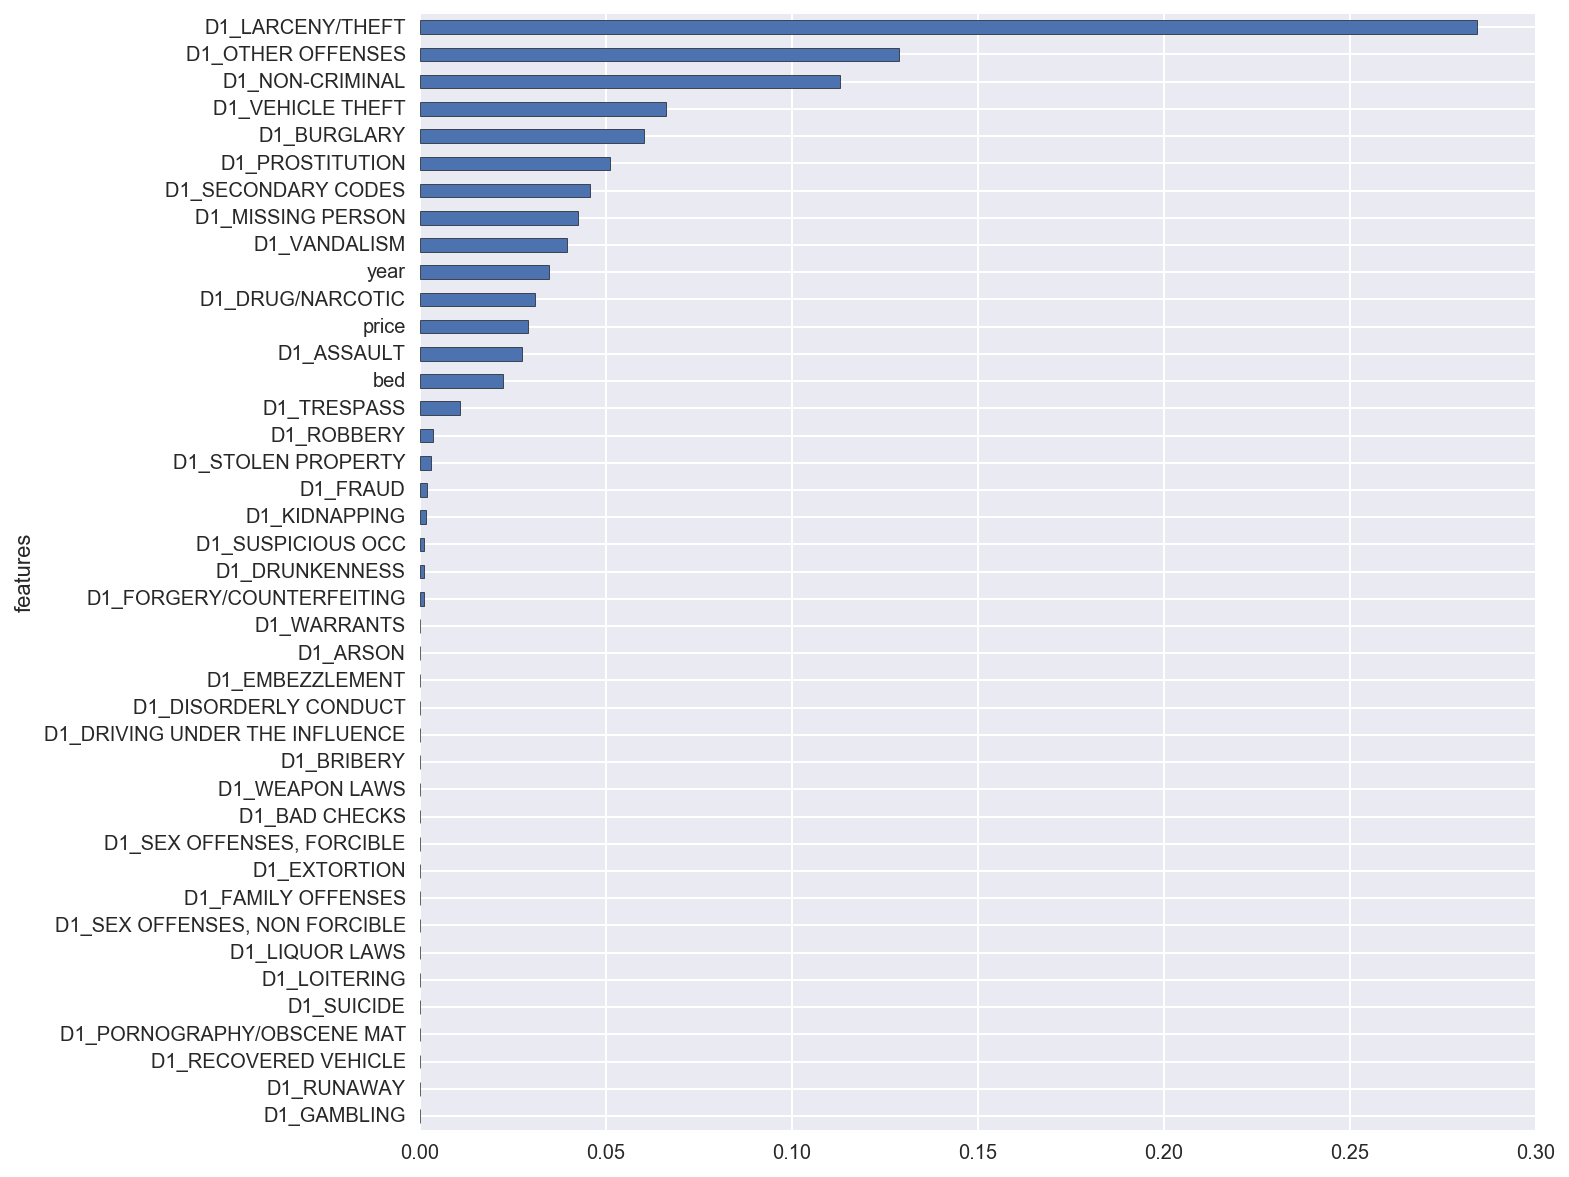

In [757]:
sns.set(rc={"figure.figsize": (10,10)})

features_df.rename(columns = {'index':'score',0:'features'},inplace = True)

features_df.set_index('features').score.sort_values().plot(kind = 'barh')

In [508]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

forest = RandomForestClassifier(random_state=0, n_estimators=1000, min_samples_split = 5)



X_train, X_test, y_train, y_test = train_test_split(D1_class, D1_target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

forest.fit(X_train, y_train)

forest_preds = forest.predict(X_test)

# forest_preds = cross_val_score(estimator = forest, X_test, y= y_test, scoring=None, cv=5, n_jobs=-1, verbose=0, fit_params=None)

forest_performance = forest.score(X_test, y_test)

print forest_preds
print forest_performance
print forest
print forest.get_params

[27 45 41 ..., 42 42 28]
0.867877222307
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
<bound method RandomForestClassifier.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)>


In [510]:
len(forest_preds)

13162

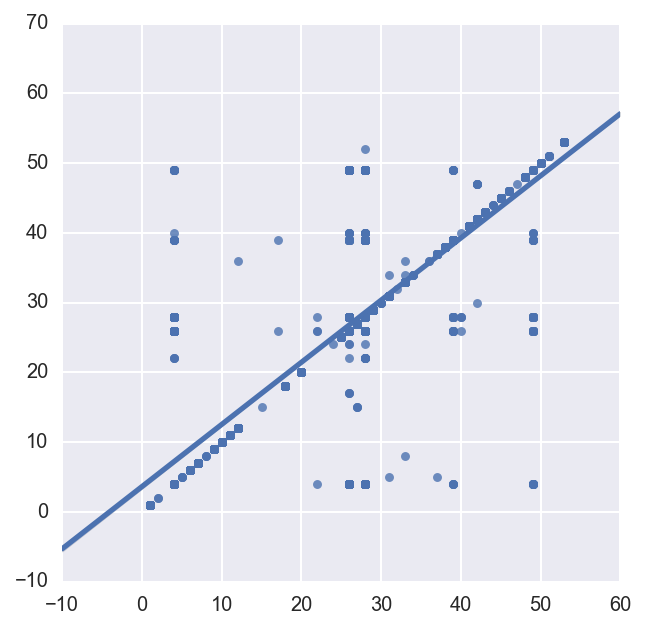

In [509]:
#multinomial naive bayes
sns.set(rc={"figure.figsize": (5, 5)})

sns.regplot(forest_preds,y_test)

In [520]:
from sklearn.metrics import roc_auc_score, roc_curve

In [522]:
print D1_target.head(), D1_class.head()

0    45
1    20
2    10
3    33
4    12
Name: district1_code, dtype: int64    D1_ARSON  D1_ASSAULT  D1_BAD CHECKS  D1_BRIBERY  D1_BURGLARY  \
0         2           9              0           0            5   
1         0           3              0           0            9   
2         0          44              0           0           16   
3         0           4              1           0           11   
4         0          11              0           0            6   

   D1_DISORDERLY CONDUCT  D1_DRIVING UNDER THE INFLUENCE  D1_DRUG/NARCOTIC  \
0                      0                               0                 1   
1                      0                               1                 2   
2                      4                               1                23   
3                      0                               2                 1   
4                      0                               0                 4   

   D1_DRUNKENNESS  D1_EMBEZZLEMENT   ...    D1_SUICID

In [563]:
def roc_curve_plot(fitted_clf):
#     n_class = X.shape[1]
#     forest = RandomForestClassifier(random_state=0, n_estimators=1000, min_samples_split = 5)
#     X_train, X_test, y_train, y_test = train_test_split(D1_class, D1_target, test_size=0.33)
#     y_train = np.ravel(y_train)
#     y_test = np.ravel(y_test)
#     forest.fit(X_train, y_train)
    y_preds = np.ravel(fitted_clf.predict_proba(X_test))
#     y_score  = fitted_clf.score
    fpr, tpr,_ = roc_curve(y_test, y_preds)
    
    try:
        print y_test[:10], y_preds[:10]
    except:
        print "something wrong"
    

In [564]:
roc_curve_plot(forest)

ValueError: Found arrays with inconsistent numbers of samples: [ 13162 618614]

# multinomial naive bayes

In [511]:
import patsy
#D1_target = past
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(D1_class, D1_target, test_size=0.33)

clf = MultinomialNB()
clf.fit(X_train,y_train)

print clf.score(X_train,y_train)

clf.predict(X_test)

0.23704202687


array([12, 28, 12, ..., 47, 12, 42])

# PCA analysis


In [560]:
tmp[D1].head()

,D1_ARSON,D1_ASSAULT,D1_BAD CHECKS,D1_BRIBERY,D1_BURGLARY,D1_DISORDERLY CONDUCT,D1_DRIVING UNDER THE INFLUENCE,D1_DRUG/NARCOTIC,D1_DRUNKENNESS,D1_EMBEZZLEMENT,...,D1_SUICIDE,D1_SUSPICIOUS OCC,D1_TRESPASS,D1_VANDALISM,D1_VEHICLE THEFT,D1_WARRANTS,D1_WEAPON LAWS,bed,year,district1_code
0,2,9,0,0,5,0,0,1,0,0,...,0,2,0,8,12,1,0,1,2003,45
1,0,3,0,0,9,0,1,2,0,1,...,1,0,0,6,14,0,0,2,2003,20
2,0,44,0,0,16,4,1,23,1,0,...,0,8,5,18,47,36,6,2,2003,10
3,0,4,1,0,11,0,2,1,1,0,...,0,1,1,5,22,3,0,0,2003,33
4,0,11,0,0,6,0,0,4,0,1,...,0,7,0,10,26,3,1,1,2003,12


In [556]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
target = np.ravel(target)

pca.fit(tmp[D1],target)
X = pca.transform(tmp[D1])

print(pca.explained_variance_ratio_) 

[ 0.72814852  0.1098488   0.06303236  0.04352567  0.01320327]


In [557]:
pca.components_
pca.n_components
pca.get_covariance()


array([[  3.34054406e+00,   2.54448244e+00,   8.02823915e-03, ...,
          5.01235837e-03,  -1.55680389e-01,   2.64010602e-01],
       [  2.54448244e+00,   1.67491711e+02,   2.13209179e-01, ...,
          2.31715328e-01,   2.67632599e-01,  -3.90842494e+00],
       [  8.02823915e-03,   2.13209179e-01,   3.28840322e+00, ...,
          4.78692500e-03,  -4.14065149e-02,   7.23532914e-01],
       ..., 
       [  5.01235837e-03,   2.31715328e-01,   4.78692500e-03, ...,
          3.30371214e+00,  -1.39017300e-01,   1.37780841e+00],
       [ -1.55680389e-01,   2.67632599e-01,  -4.14065149e-02, ...,
         -1.39017300e-01,   8.49262433e+00,  -1.24156120e+00],
       [  2.64010602e-01,  -3.90842494e+00,   7.23532914e-01, ...,
          1.37780841e+00,  -1.24156120e+00,   1.75271704e+02]])

In [558]:
crime_pca_target = pd.DataFrame({'price':target})
print crime_pca_target.shape,X.shape
crime_pca = crime_pca_target.join(pd.DataFrame(X))
crime_pca.rename(columns = {0:'pc1',1:'pc2'},inplace=True)
print crime_pca.shape
crime_pca.head()


(39883, 1) (39883, 5)
(39883, 6)


,price,pc1,pc2,2,3,4
0,950.0,15.652296,-7.287400,15.069552,-2.105224,-1.542577
1,1500.0,2.336033,14.841984,-9.274070,-8.097824,-2.586920
2,1795.0,-114.880282,11.484385,-17.945980,-11.692813,12.207798
3,1180.0,8.242827,-0.061770,3.817555,-13.656003,0.451352
4,1100.0,-10.312753,-3.935832,-17.082094,-12.663304,0.019543


0


TypeError: 'numpy.float64' object is not iterable

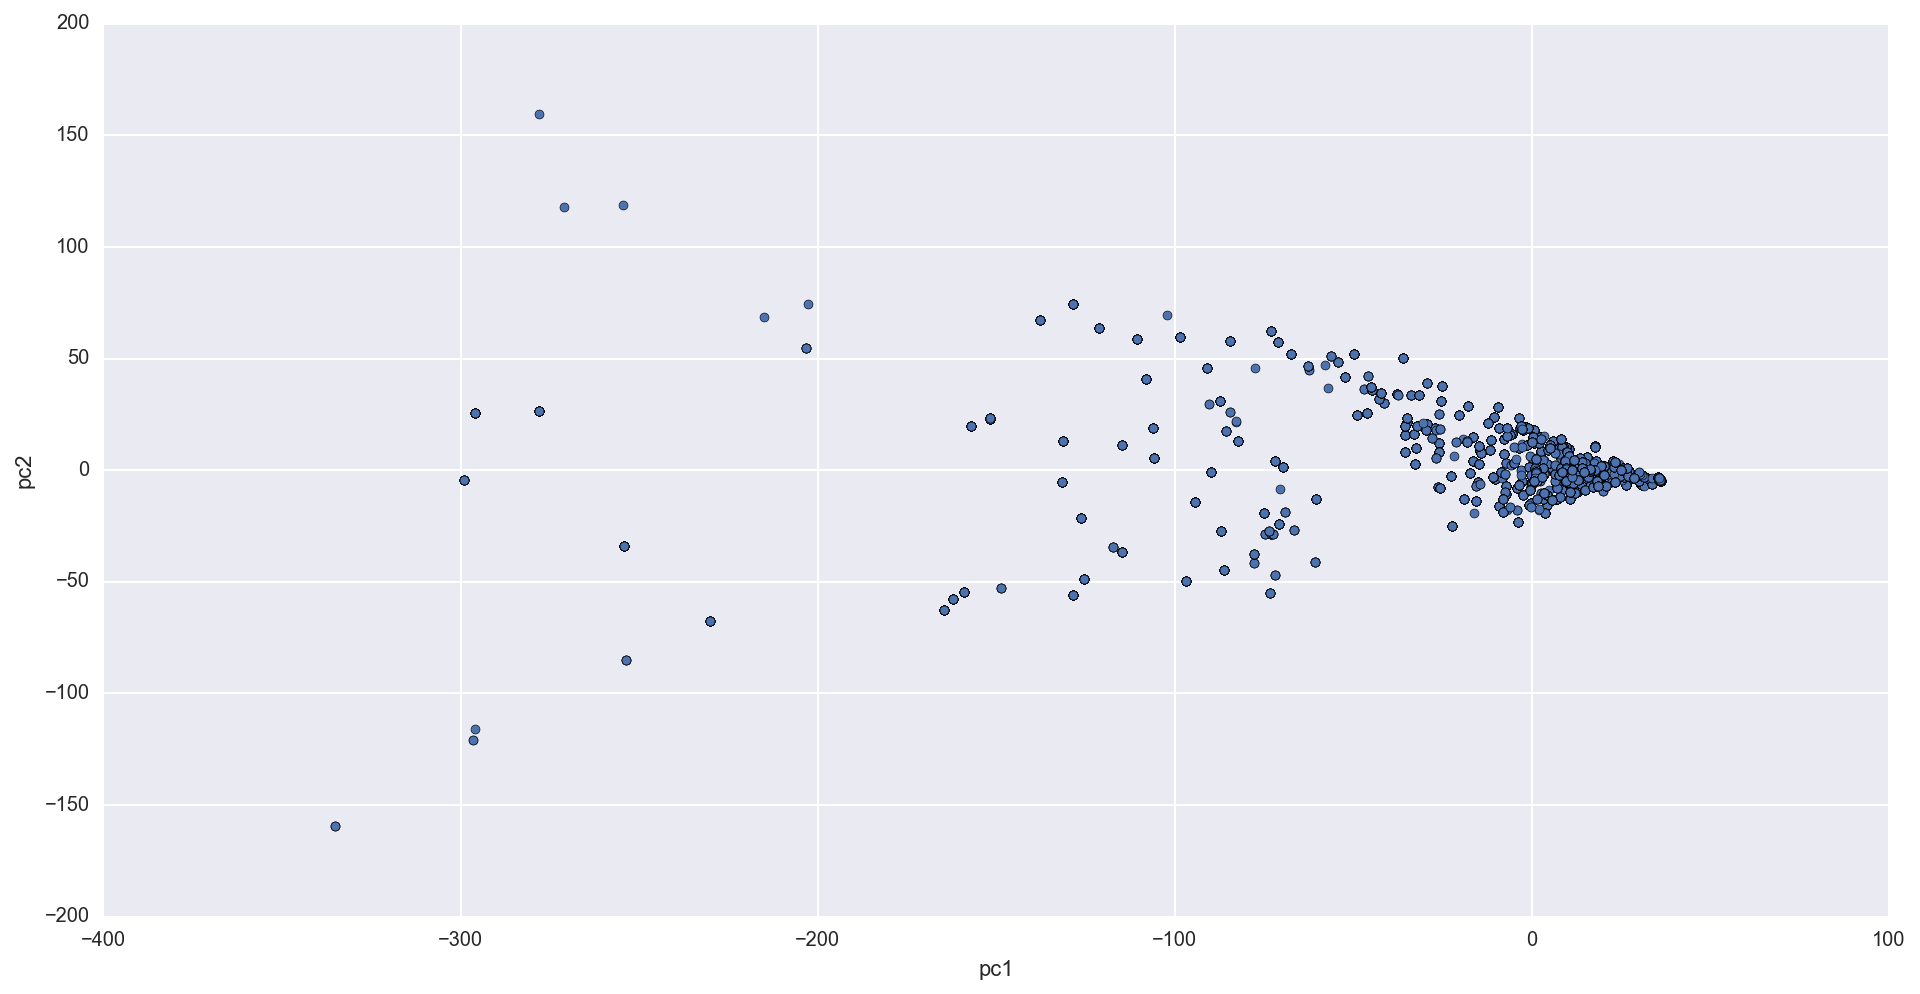

In [559]:
sns.set(rc={"figure.figsize": (5, 5)})

pd.DataFrame(X)
graph = crime_pca.plot(kind='scatter', x='pc1', y='pc2', figsize=(16,8))

for p in crime_pca.index:
    print p
    graph.annotate(crime_pca.iloc[p]['price'], crime_pca.iloc[p].pc2, crime_pca.iloc[p].pc1)


# DAVE WHAT IS THIS AND HOW DO I PREEDICT CRIME LEVELS IN DIFFERENT NEIGHBORHOODS

In [ ]:
# pull up components
#classification report decision recall roc
# feature selection sklearn anova

# Predict Crime Levels

In [196]:
D1_class['district_code'] = D1_target
pred_crime = D1_class

/Users/Stav/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


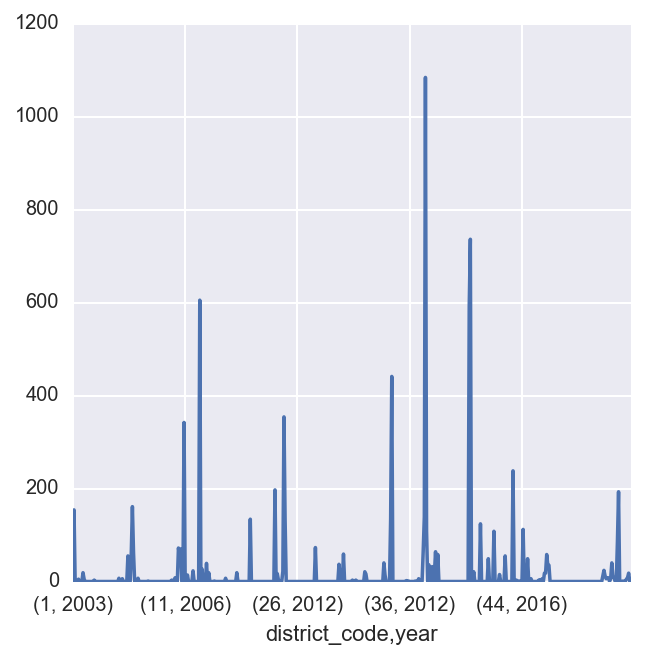

In [202]:
pred_crime.groupby(['district_code','year']).sum().D1_ARSON.plot()

In [126]:
from sklearn.tree import DecisionTreeRegressor
#rmp = posts_crimes[[col for col in posts_crimes if posts_crimes[col].dtype != object]]
regressor = DecisionTreeRegressor(criterion='mse',max_depth = 5)

model = regressor.fit(tmp, target)

Y_pred = regressor.predict(tmp)

print model.score(tmp,Y_pred)

1.0


In [180]:
tmp.head()

,D1_ARSON,D1_ASSAULT,D1_BAD CHECKS,D1_BRIBERY,D1_BURGLARY,D1_DISORDERLY CONDUCT,D1_DRIVING UNDER THE INFLUENCE,D1_DRUG/NARCOTIC,D1_DRUNKENNESS,D1_EMBEZZLEMENT,...,D3_TRESPASS,D3_VANDALISM,D3_VEHICLE THEFT,D3_WARRANTS,D3_WEAPON LAWS,bed,year,district1_code,district2_code,district3_code
0,0,9,0,0,4,1,0,1,0,0,...,1,7,12,7,0,1,2003,45,36,13
1,0,9,0,0,10,0,0,0,1,0,...,0,0,0,0,0,2,2003,20,26,26
2,1,54,0,0,19,2,1,32,3,0,...,1,21,48,30,10,2,2003,10,27,51
3,1,3,1,0,6,0,0,0,0,0,...,2,12,18,7,1,0,2003,33,40,12
4,0,20,0,0,6,0,1,2,0,0,...,1,7,12,7,0,1,2003,12,32,13


In [247]:
evictions = pd.read_csv('./Eviction_Notices.csv')

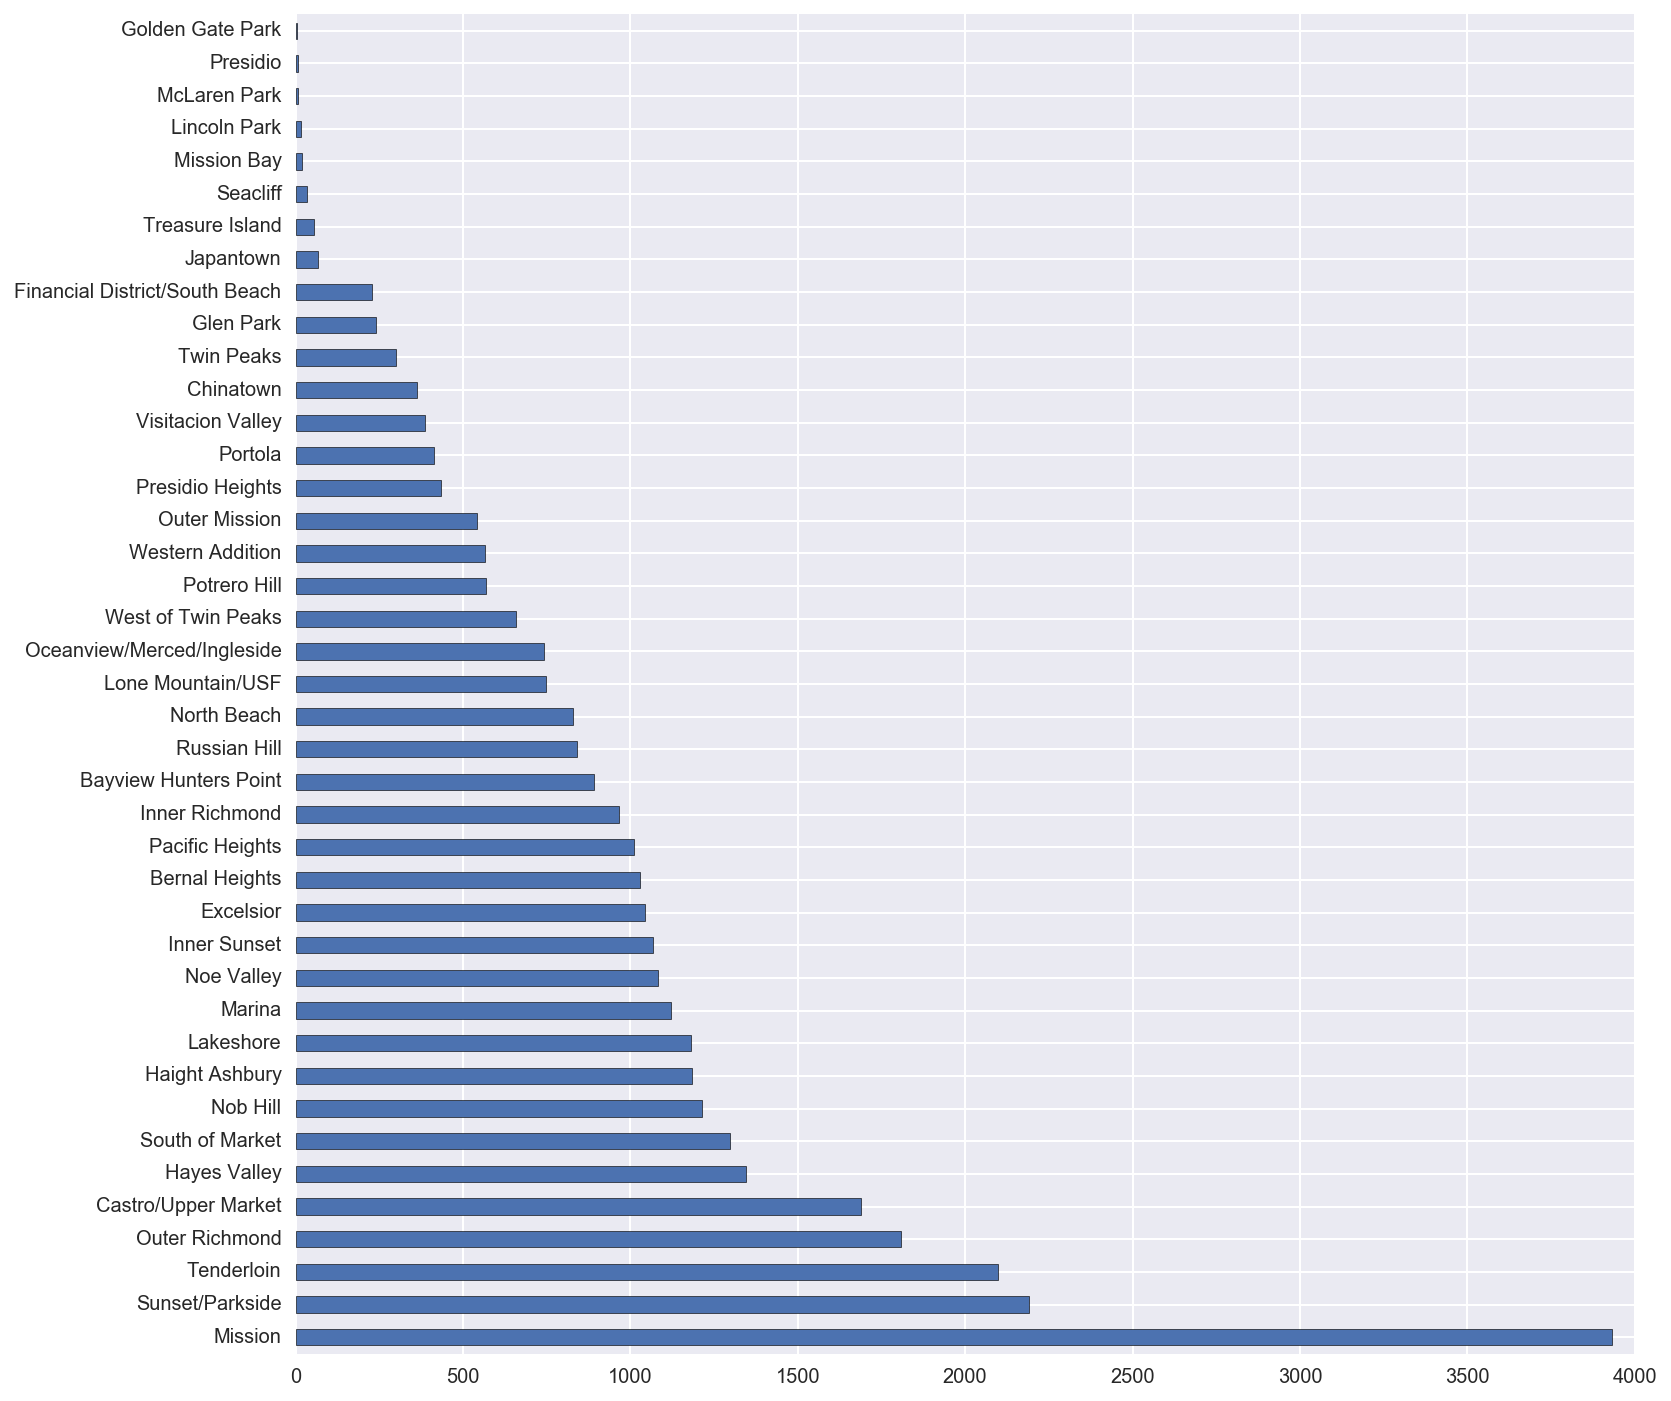

In [248]:
sns.set(rc={"figure.figsize": (12, 12)})
evictions['Neighborhoods - Analysis Boundaries'].value_counts().plot(kind = 'barh')

In [249]:
print evictions.Breach.value_counts()
print evictions['Owner Move In'].value_counts()
print evictions['Late Payments'].value_counts()
print evictions['Illegal Use'].value_counts()


False    27856
True      7799
Name: Breach, dtype: int64
False    26415
True      9240
Name: Owner Move In, dtype: int64
False    34209
True      1446
Name: Late Payments, dtype: int64
False    34918
True       737
Name: Illegal Use, dtype: int64


In [250]:
evictions['File Date'] = pd.to_datetime(evictions['File Date'])

In [251]:
evictions.set_index('File Date', inplace = True)
evictions['year'] = evictions.index.map(lambda val: val.year)


In [252]:
evictions = evictions[evictions.year >= 2003]

In [907]:
geoms = pd.read_csv('/Users/Stav/Downloads/planning_neighborhoods.csv')
geoms.neighborho = geoms.neighborho.apply(lambda x: x.lower())

In [927]:
# filter mask
posts_crimes_filter = posts_crimes[(posts_crimes['bed'] == 1) & (posts_crimes['year'] == 2015)]
price_mean = pd.DataFrame(posts_crimes_filter.groupby(['district1']).median().price).reset_index()

In [933]:
geoms.rename(columns = {'neighborho': 'district1'}, inplace = True)
geoms.district1 = geoms.district1.apply(lambda x: 'mission district' if x == 'mission' else x)
price_mean.district1 = price_mean.district1.apply(lambda x: 'downtown/civic center' if x == 'tenderloin' else x)
price_mean.district1 = price_mean.district1.apply(lambda x: 'downtown/civic center' if x == 'tenderloin' else x)
price_mean.district1 = price_mean.district1.apply(lambda x: 'sunset district' if x == 'sunset' else x)
price_mean.district1 = price_mean.district1.apply(lambda x: 'castro/upper market' if x == 'castro' else x)
price_mean.district1 = price_mean.district1.apply(lambda x: 'diamond heights' if x == 'west of twin peaks' else x)
price_mean.district1 = price_mean.district1.apply(lambda x: 'outer sunset' if x == 'sunset district' else x)
price_mean.district1 = price_mean.district1.apply(lambda x: 'ocean view' if x == 'oceanview' else x)
price_mean.district1 = price_mean.district1.apply(lambda x: 'west of twin peaks' if x == 'usf' else x)
price_mean.district1 = price_mean.district1.apply(lambda x: 'bayview' if x == 'mission bay' else x)

In [941]:

new_geoms = geoms.merge(price_mean)
new_geoms.to_csv('/Users/Stav/Desktop/new_geoms_filter.csv')

In [943]:
new_geoms.head()

,cartodb_id,the_geom,district1,price
0,1,0106000020E61000000100000001030000000100000034...,seacliff,2600.0
1,20,0106000020E61000001100000001030000000400000000...,marina,3350.0
2,32,0106000020E6100000010000000103000000010000000E...,nob hill,3083.5
3,34,0106000020E610000040000000010300000001000000D4...,north beach,3060.0
4,27,0106000020E610000001000000010300000002000000F7...,potrero hill,3500.0


![alt text](https://snag.gy/d0oeIV.jpg)